# VE Net

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import gpytorch

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm

## Load Data

In [50]:
# model hyperparameters
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

num_seeds = 300
seed = 0

all_state_dim = 64
state_dim = 64
action_dim = 19
training_seed = 300

# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"data/HEBB-full/HEBB-FULL_STATE-seed_{seed}-fullstate-rand-{i}.npz")    
    
train_x = torch.empty((0, all_state_dim), dtype=torch.float32 ,device=DEVICE)
train_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
test_x = torch.empty((0, all_state_dim), dtype=torch.float32,device=DEVICE)
test_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
for i in range(training_seed):
    train_x = torch.cat((train_x, torch.tensor(data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    train_y = torch.cat((train_y, torch.tensor(data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
for j in range(training_seed, num_seeds):
    test_x = torch.cat((test_x, torch.tensor(data_fullstate[j]["state"].reshape(data_fullstate[j]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    test_y = torch.cat((test_y, torch.tensor(data_fullstate[j]["action_lowpass"].reshape(data_fullstate[j]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)

In [51]:
train_x.shape

torch.Size([150000, 64])

## Model

In [52]:
"""
    A simple implementation of Gaussian MLP Encoder
"""
class Predictor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.FC_mean  = nn.Linear(hidden_dim, output_dim)
        self.FC_var   = nn.Linear (hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        self.LeakyReLU = nn.ReLU()
        self.softplus = nn.Softplus()
        
        self.training = True
        
    def reparameterization(self , mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
    
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        mean     = self.FC_mean(h_)         # encoder produces mean and log of variance 
        log_var  = self.FC_var(h_)          # (i.e., parateters of simple tractable normal distribution "q"
        
        # log_var  = self.softplus(log_var)  # clamp log_var to avoid numerical issues
        
        z = self.reparameterization(mean, torch.exp(log_var))  # reparameterization trick
        # z is sampling from the distribution z = mean + var * epsilon
        
        return z,mean, log_var

In [53]:
MSEloss = nn.MSELoss()

### Eva model function

In [54]:
eva_input = train_x[2500:3000 , :]
eva_label = train_y[2500:3000 , :]

dim  = 19
cols = 3
rows = math.ceil(dim / cols)

# ตั้งค่าสถานะว่า eva_sigma เป็น std หรือ var
ASSUME_SIGMA_IS_STD = False  # ถ้า eva_sigma คือ std ให้ True, ถ้าเป็น variance อยู่แล้ว ให้ False

In [55]:
def plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
    axes = axes.flatten()

    for d in range(dim):
        ax = axes[d]
        mu   = mu_np[:, d]
        var  = var_np[:, d]
        pred = pred_np[:, d]
        std  = np.sqrt(var)
        lo   = mu - 1.96 * std
        up   = mu + 1.96 * std
        y    = y_np[:, d]

        T = mu_np.shape[0]
        x = np.arange(T)


        # เส้น mean
        ax.plot(x, pred, label=f"predicted (dim {d})")
        ax.plot(x, y, label=f"label (dim {d})")
        ax.plot(x, mu, label=f"mean (dim {d})")
        # แถบ 95% CI
        ax.fill_between(x, lo, up, alpha=0.8, label="95% CI")

        ax.set_title(f"Dim {d}")
        ax.grid(True)

    fig.tight_layout()
    # ดึง legend จากซับพล็อตแรกเพื่อลดความรก
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
    plt.show()
    
def plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
    axes = axes.flatten()

    T = mu_np.shape[0]
    x = np.arange(T)

    for d in range(dim):
        ax = axes[d]
        mu   = mu_np[:, d]
        var  = var_np[:, d]
        pred = pred_np[:, d]
        std  = np.sqrt(var)
        lo   = mu - 1.96 * std
        up   = mu + 1.96 * std
        y    = y_np[:, d]
        # แถบ 95% CI
        ax.fill_between(x, lo, up, alpha=0.8, label="95% CI")

        ax.set_title(f"Dim {d}")
        ax.grid(True)

    fig.tight_layout()
    # ดึง legend จากซับพล็อตแรกเพื่อลดความรก
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
    plt.show()

## Train Function

In [56]:
# ----- Training Loop -----
def train_model(model,optimizer,epochs,train_loader , len_train_dataset , len_test_dataset):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(DEVICE)    # dim = [batch_size, state_dim]
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()
            pred, mean , log_var = model(x_batch)
            loss = MSEloss(pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)

        avg_loss = total_loss / len_train_dataset
        train_losses.append(avg_loss)

        # ----- Evaluate -----
        # model.eval()
        # total_test_loss = 0.0
        # with torch.no_grad():
        #     for x_batch, y_batch in test_loader:
        #         x_batch = x_batch.to(DEVICE)
        #         y_batch = y_batch.to(DEVICE)
        #         pred, mean , log_var = model(x_batch)
        #         total_test_loss += MSEloss(pred, y_batch).item() * x_batch.size(0)

        # avg_test_loss = total_test_loss / len_test_dataset
        # test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f}")
    return train_losses #, test_losses

In [57]:
def plot_loss(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [58]:
def evaluate_model(model, input, label):
    eva_pred , eva_mean , eva_log_var = model(input)
    # เตรียมแกน x (จะพล็อตตามลำดับ index ของ sample)
    T = eva_mean.shape[0]
    x = np.arange(T)

    # แปลงเป็น numpy
    y_np = label.detach().cpu().numpy()
    pred_np = eva_pred.detach().cpu().numpy()
    mu_np  = eva_mean.detach().cpu().numpy()                   # [T, 19]
    sig_np = torch.exp(eva_log_var).detach().cpu().numpy()                  # [T, 19]
    var_np = (sig_np**2) if ASSUME_SIGMA_IS_STD else sig_np    # [T, 19]
    return y_np, pred_np, mu_np, var_np

### Hyperparams

get data frame

In [59]:
output_dim = 19 # same as all model
epochs = 150

In [60]:
state_index = torch.arange(0, 19)

pos_index = torch.arange(0, 19) # pos
vel_index = torch.arange(19, 38) # vel
action_index = torch.arange(38, 57) # vel
IMU_index = torch.arange(57, 60)
fc_index = torch.arange(60, 64)

pos_dataset = TensorDataset(train_x[:,pos_index], train_y)
vel_dataset = TensorDataset(train_x[:,vel_index], train_y)
action_dataset = TensorDataset(train_x[:,action_index], train_y)
IMU_dataset = TensorDataset(train_x[:,IMU_index], train_y)
fc_dataset = TensorDataset(train_x[:,fc_index], train_y)

# action_loader = DataLoader(action_dataset, batch_size=batch_size)
# IMU_loader = DataLoader(IMU_dataset, batch_size=batch_size)
# fc_loader = DataLoader(fc_dataset, batch_size=batch_size)

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

len_train_dataset = len(pos_dataset)
len_test_dataset = len(pos_dataset)

TRAIN : X , Y shape :  torch.Size([150000, 19]) torch.Size([150000, 19])
TEST : X , Y shape :  torch.Size([0, 19]) torch.Size([0, 19])


## Joint Pos model

### Train

In [61]:
# tuned
batch_size = 1024

state_dim = len(pos_index)
hidden_dim = 1024
lr = 0.0002699130168364922
pos_loader = DataLoader(pos_dataset, batch_size=batch_size)

model_joint_pos = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_joint_pos = Adam(model_joint_pos.parameters(), lr=lr)

Epoch 1/150 | Train Loss: 0.077769
Epoch 2/150 | Train Loss: 0.029405
Epoch 3/150 | Train Loss: 0.027251
Epoch 4/150 | Train Loss: 0.025476
Epoch 5/150 | Train Loss: 0.023700
Epoch 6/150 | Train Loss: 0.022271
Epoch 7/150 | Train Loss: 0.021180
Epoch 8/150 | Train Loss: 0.020369
Epoch 9/150 | Train Loss: 0.019773
Epoch 10/150 | Train Loss: 0.019323
Epoch 11/150 | Train Loss: 0.018970
Epoch 12/150 | Train Loss: 0.018694
Epoch 13/150 | Train Loss: 0.018465
Epoch 14/150 | Train Loss: 0.018276
Epoch 15/150 | Train Loss: 0.018117
Epoch 16/150 | Train Loss: 0.017981
Epoch 17/150 | Train Loss: 0.017862
Epoch 18/150 | Train Loss: 0.017759
Epoch 19/150 | Train Loss: 0.017666
Epoch 20/150 | Train Loss: 0.017583
Epoch 21/150 | Train Loss: 0.017506
Epoch 22/150 | Train Loss: 0.017434
Epoch 23/150 | Train Loss: 0.017367
Epoch 24/150 | Train Loss: 0.017303
Epoch 25/150 | Train Loss: 0.017243
Epoch 26/150 | Train Loss: 0.017187
Epoch 27/150 | Train Loss: 0.017133
Epoch 28/150 | Train Loss: 0.017080
E

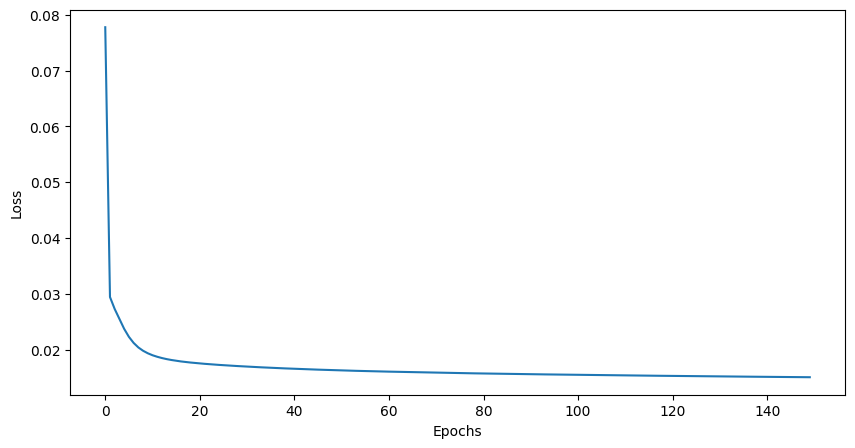

In [62]:
jp_train_loss =train_model(model_joint_pos,optimizer_joint_pos,epochs,pos_loader , len_train_dataset , len_test_dataset)
plot_loss(jp_train_loss)
print(min(jp_train_loss))

save_model :)

In [63]:
torch.save(model_joint_pos.state_dict(), f"model/HEBB-joint_pos.pth")
torch.save(jp_train_loss, f"loss/joint_pos.pth")

### Evaluate model

In [64]:
state_dict = torch.load(f"model/HEBB-joint_pos.pth")
model_joint_pos.load_state_dict(state_dict)

<All keys matched successfully>

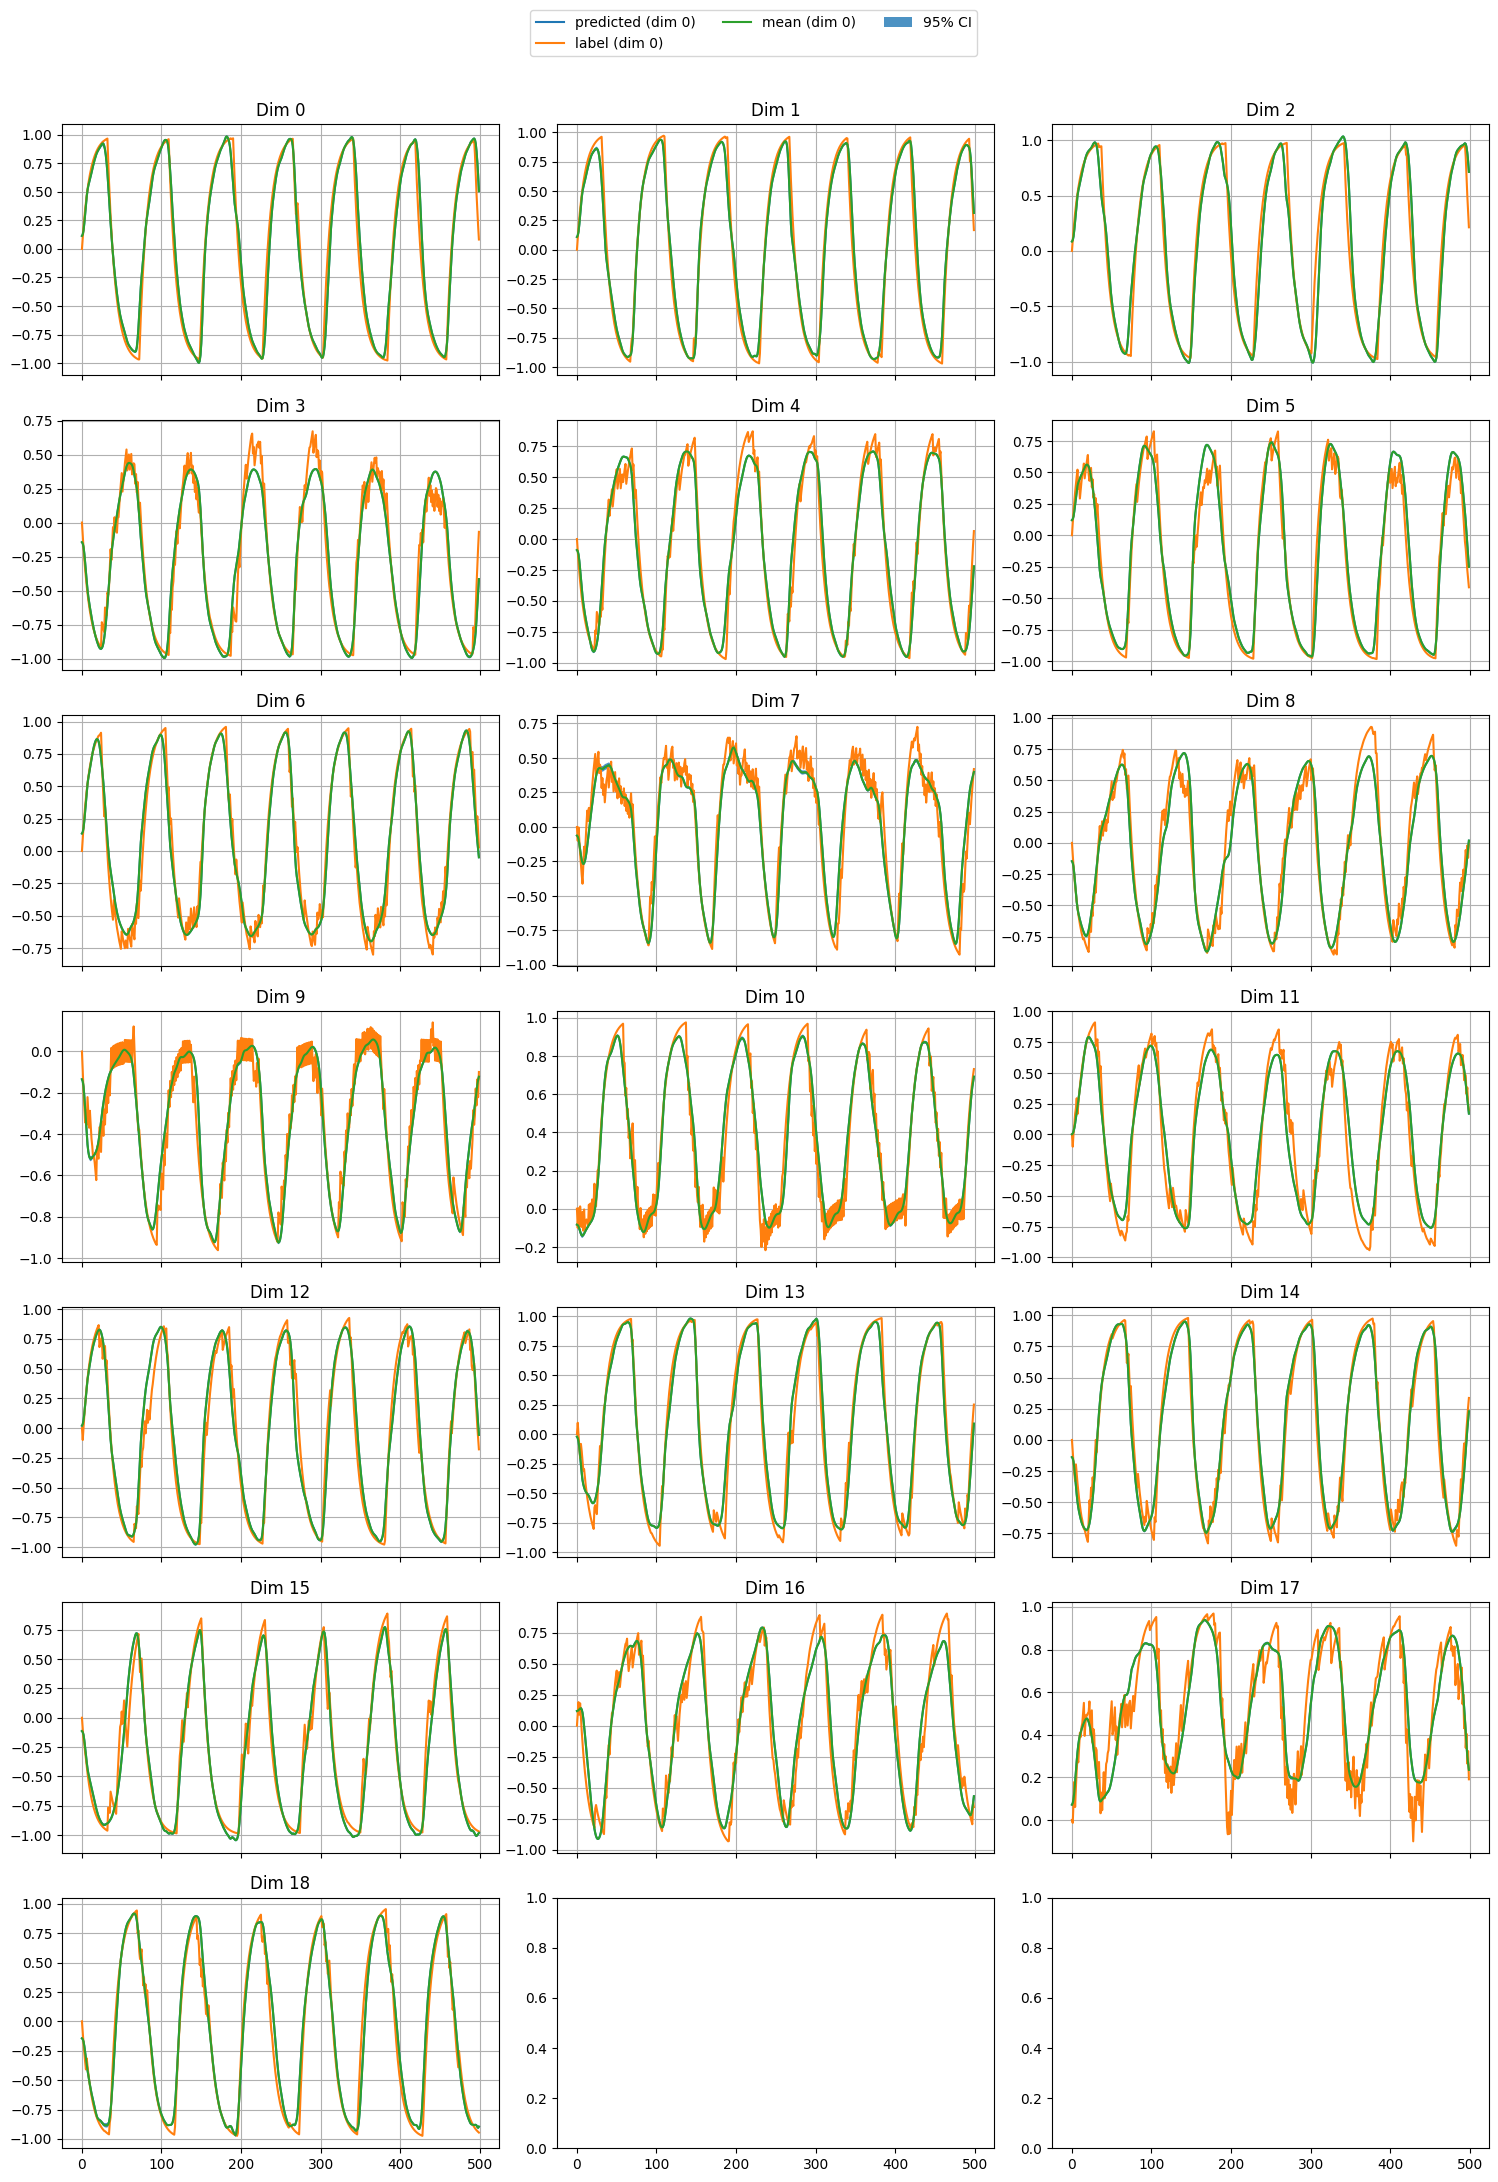

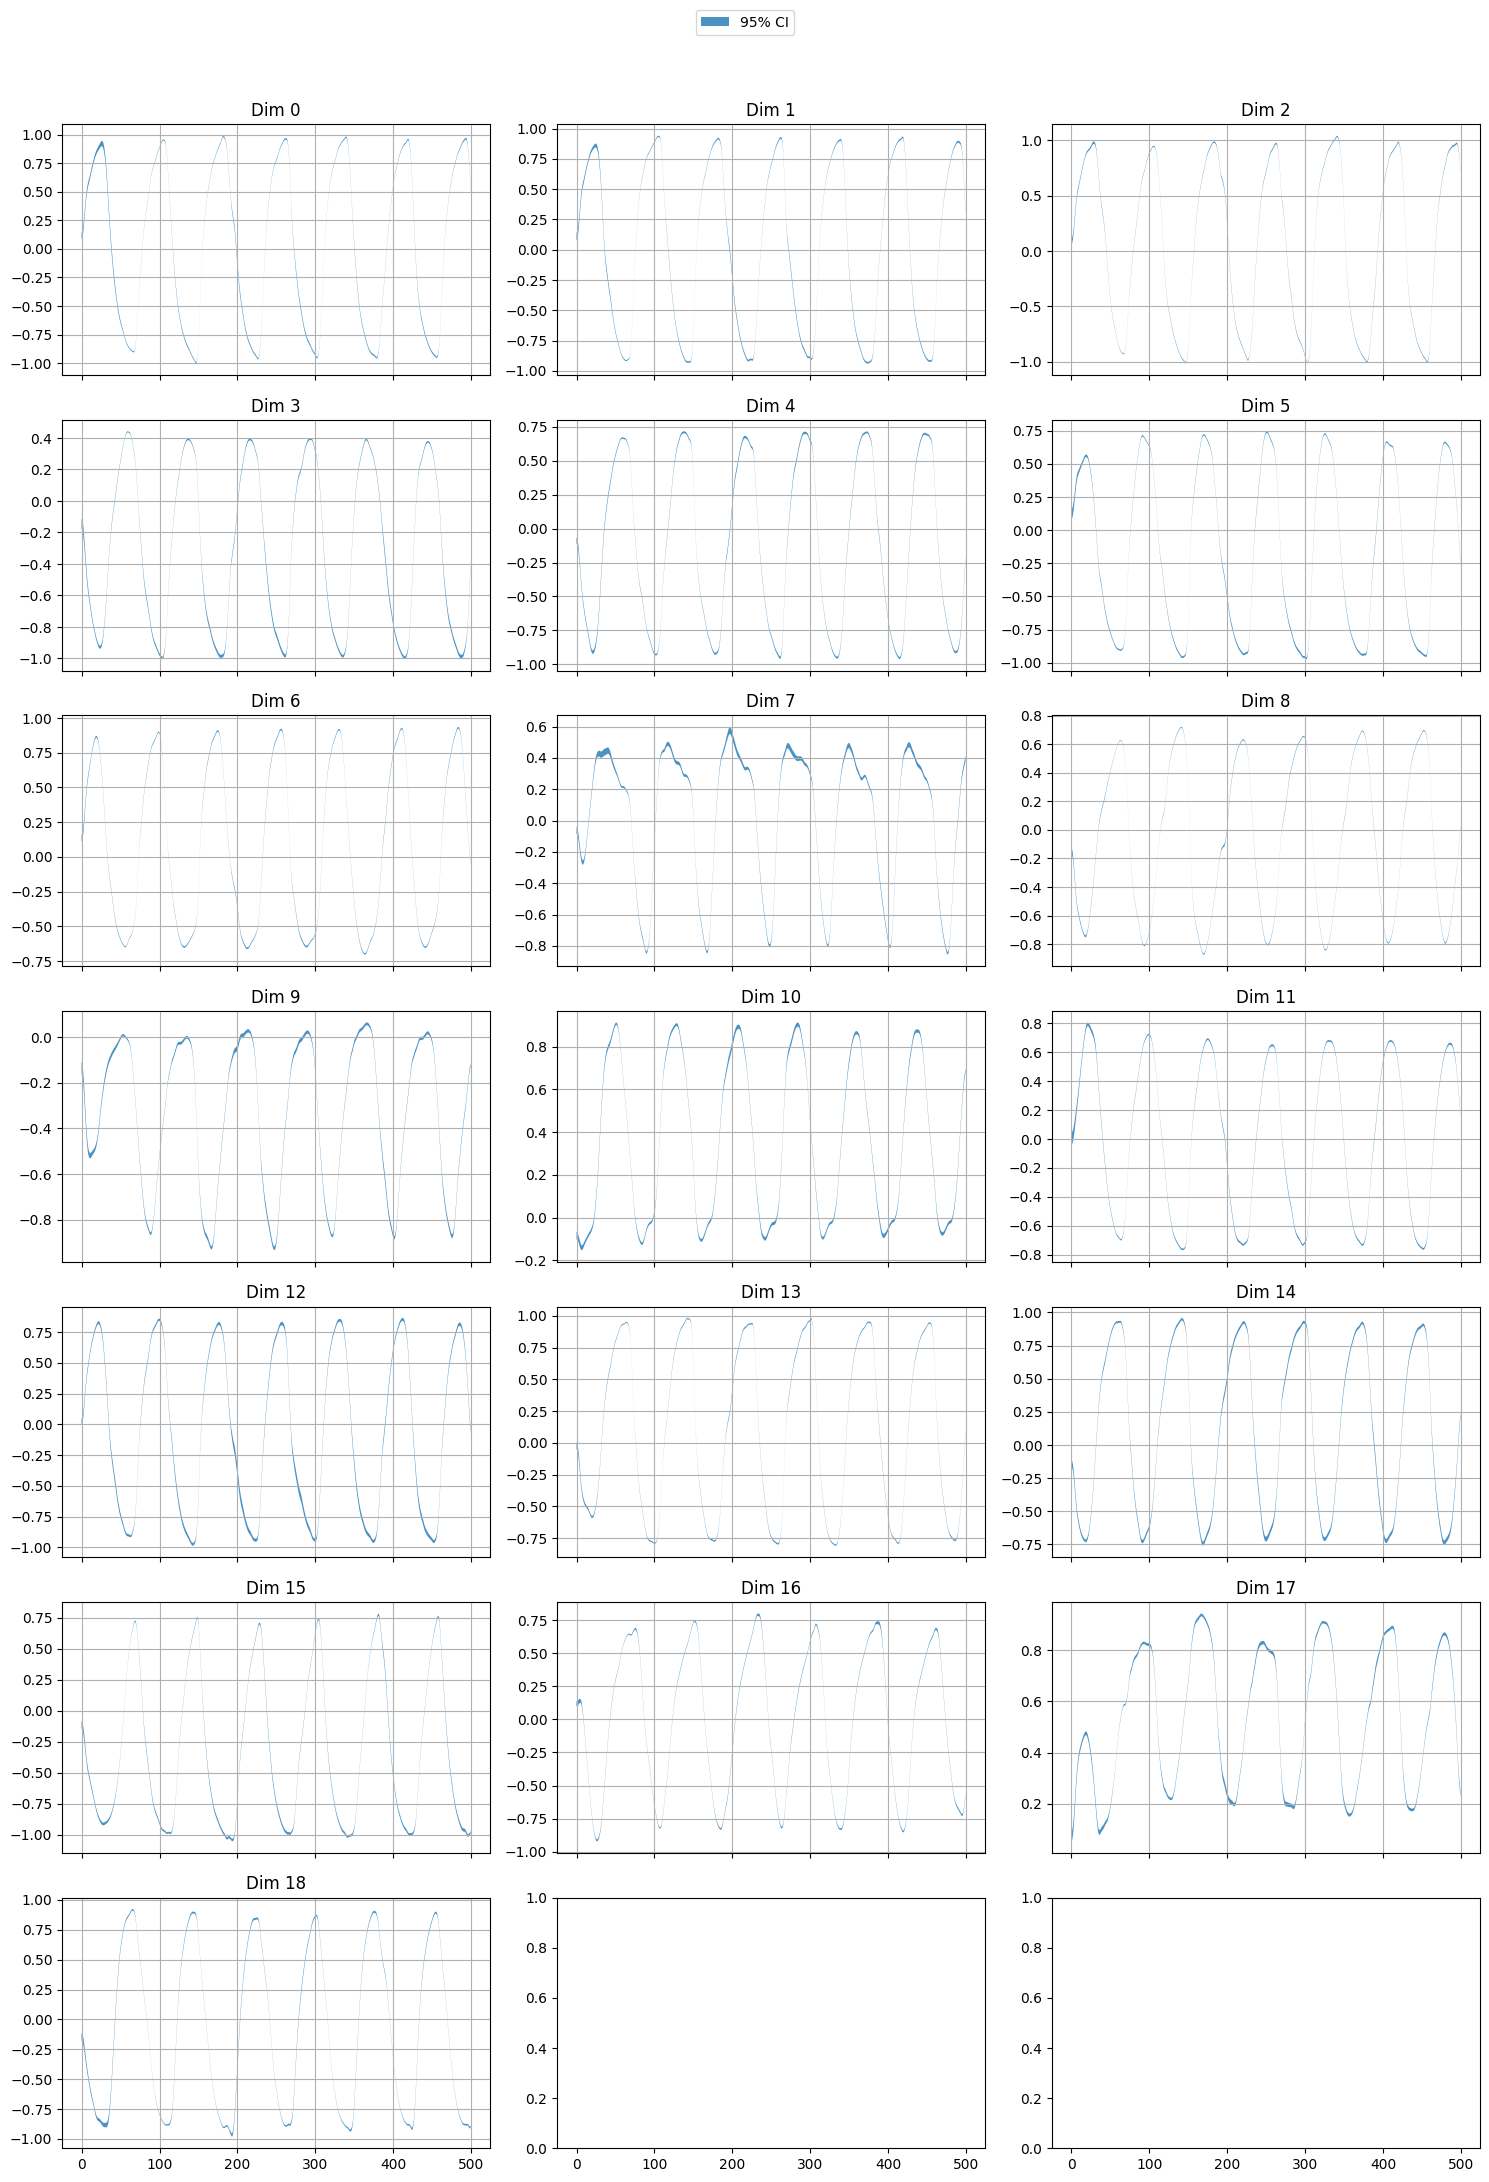

In [65]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_joint_pos, eva_input[:,pos_index], eva_label)
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)

## Joint Vel model

### Train

In [66]:
# Tuned
batch_size = 128
hidden_dim = 1024
lr = 0.0001407978650876854

state_dim = len(vel_index)

vel_loader = DataLoader(vel_dataset, batch_size=batch_size)
model_joint_vel = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_joint_vel = Adam(model_joint_vel.parameters(), lr=lr)

Epoch 1/150 | Train Loss: 0.029741
Epoch 2/150 | Train Loss: 0.013467
Epoch 3/150 | Train Loss: 0.012837
Epoch 4/150 | Train Loss: 0.012417
Epoch 5/150 | Train Loss: 0.012064
Epoch 6/150 | Train Loss: 0.011756
Epoch 7/150 | Train Loss: 0.011485
Epoch 8/150 | Train Loss: 0.011248
Epoch 9/150 | Train Loss: 0.011043
Epoch 10/150 | Train Loss: 0.010864
Epoch 11/150 | Train Loss: 0.010710
Epoch 12/150 | Train Loss: 0.010576
Epoch 13/150 | Train Loss: 0.010460
Epoch 14/150 | Train Loss: 0.010359
Epoch 15/150 | Train Loss: 0.010271
Epoch 16/150 | Train Loss: 0.010194
Epoch 17/150 | Train Loss: 0.010126
Epoch 18/150 | Train Loss: 0.010066
Epoch 19/150 | Train Loss: 0.010013
Epoch 20/150 | Train Loss: 0.009966
Epoch 21/150 | Train Loss: 0.009924
Epoch 22/150 | Train Loss: 0.009885
Epoch 23/150 | Train Loss: 0.009850
Epoch 24/150 | Train Loss: 0.009817
Epoch 25/150 | Train Loss: 0.009786
Epoch 26/150 | Train Loss: 0.009758
Epoch 27/150 | Train Loss: 0.009731
Epoch 28/150 | Train Loss: 0.009706
E

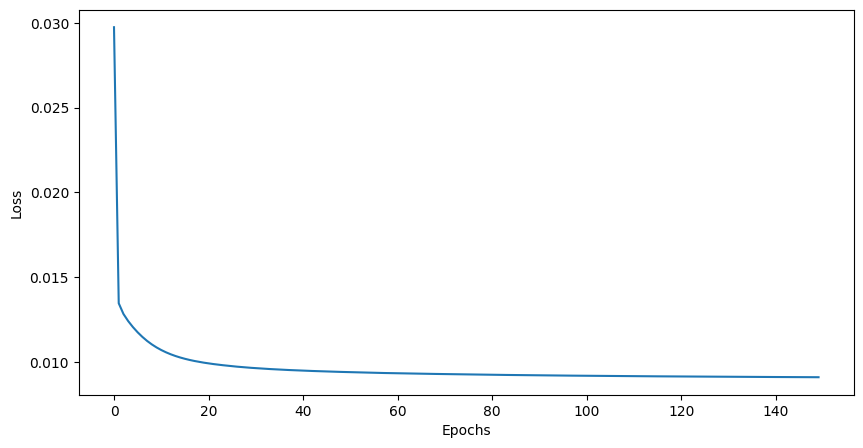

In [67]:
jv_train_loss=train_model(model_joint_vel,optimizer_joint_vel,epochs,vel_loader , len_train_dataset , len_test_dataset)
plot_loss(jv_train_loss)
print(min(jv_train_loss))

In [68]:
torch.save(jv_train_loss, f"loss/joint_vel.pth")
torch.save(model_joint_pos.state_dict(), f"model/HEBB-joint_vel.pth")

### Evaluate

In [69]:
state_dict = torch.load(f"model/HEBB-joint_vel.pth")
model_joint_vel.load_state_dict(state_dict)

<All keys matched successfully>

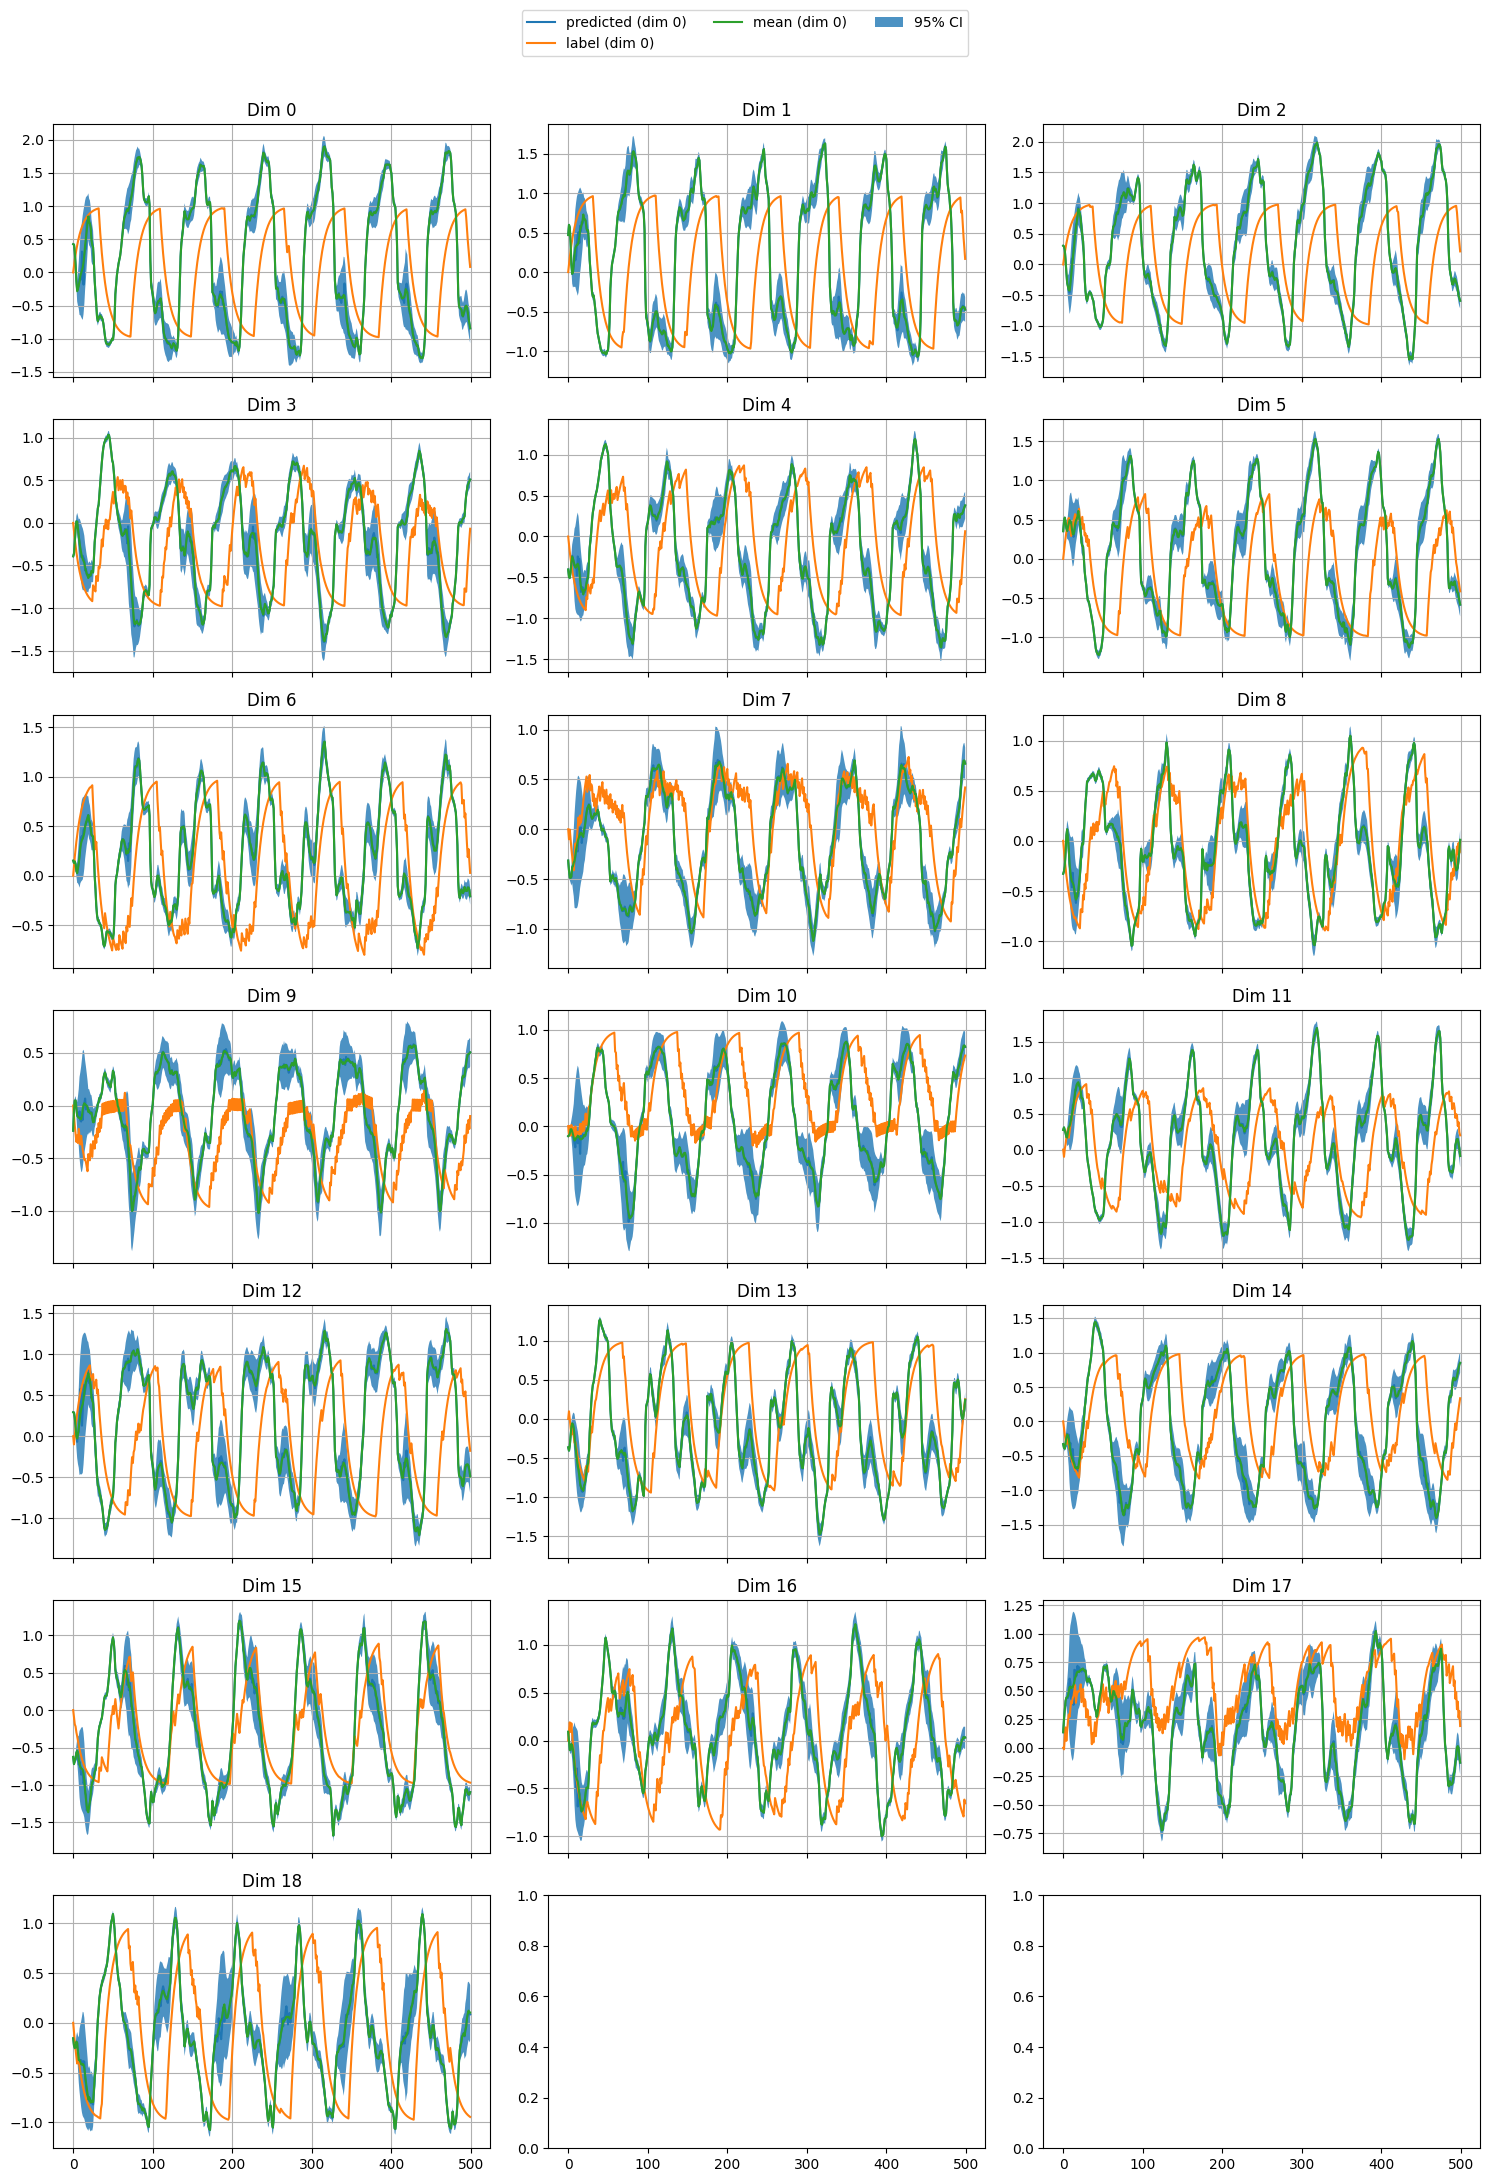

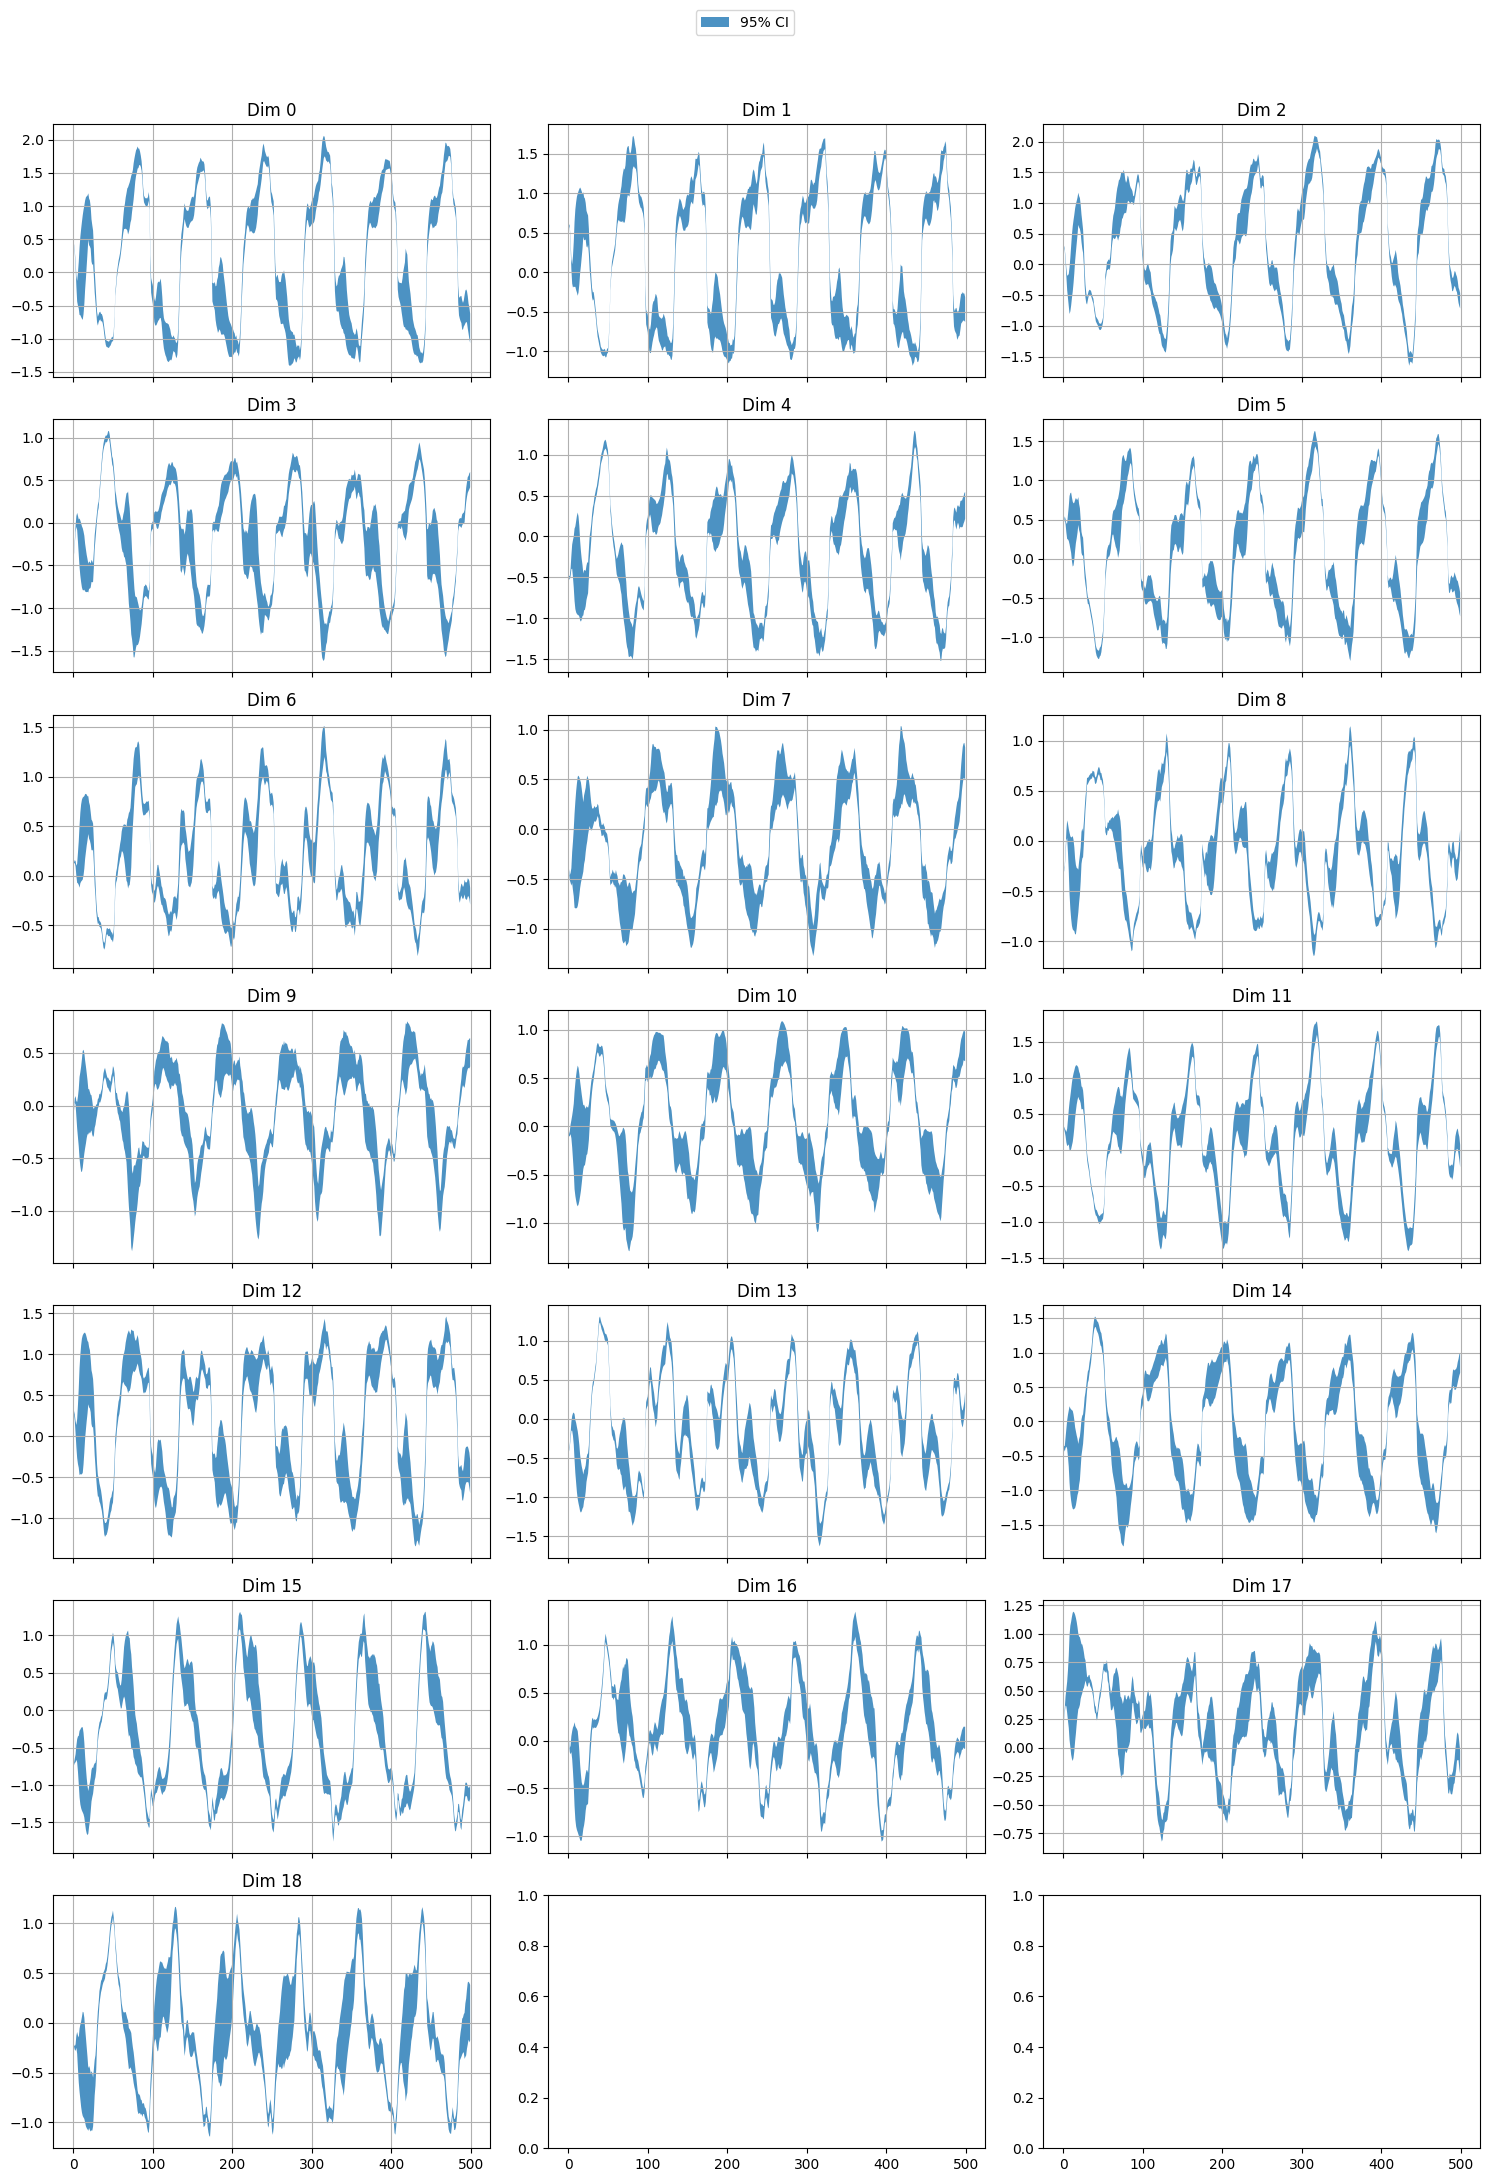

In [70]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_joint_vel, eva_input[:,vel_index], eva_label)
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)

## Joint action

In [71]:
# tuned
batch_size = 128
hidden_dim = 1024
lr = 3.564158178147666e-05

state_dim = len(action_index)
action_loader = DataLoader(action_dataset, batch_size=batch_size)

model_action = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_action = Adam(model_action.parameters(), lr=lr)

Epoch 1/150 | Train Loss: 0.097898
Epoch 2/150 | Train Loss: 0.041159
Epoch 3/150 | Train Loss: 0.039050
Epoch 4/150 | Train Loss: 0.038192
Epoch 5/150 | Train Loss: 0.037705
Epoch 6/150 | Train Loss: 0.037366
Epoch 7/150 | Train Loss: 0.037110
Epoch 8/150 | Train Loss: 0.036904
Epoch 9/150 | Train Loss: 0.036733
Epoch 10/150 | Train Loss: 0.036588
Epoch 11/150 | Train Loss: 0.036461
Epoch 12/150 | Train Loss: 0.036348
Epoch 13/150 | Train Loss: 0.036245
Epoch 14/150 | Train Loss: 0.036152
Epoch 15/150 | Train Loss: 0.036066
Epoch 16/150 | Train Loss: 0.035986
Epoch 17/150 | Train Loss: 0.035911
Epoch 18/150 | Train Loss: 0.035841
Epoch 19/150 | Train Loss: 0.035775
Epoch 20/150 | Train Loss: 0.035712
Epoch 21/150 | Train Loss: 0.035653
Epoch 22/150 | Train Loss: 0.035595
Epoch 23/150 | Train Loss: 0.035541
Epoch 24/150 | Train Loss: 0.035488
Epoch 25/150 | Train Loss: 0.035437
Epoch 26/150 | Train Loss: 0.035388
Epoch 27/150 | Train Loss: 0.035340
Epoch 28/150 | Train Loss: 0.035293
E

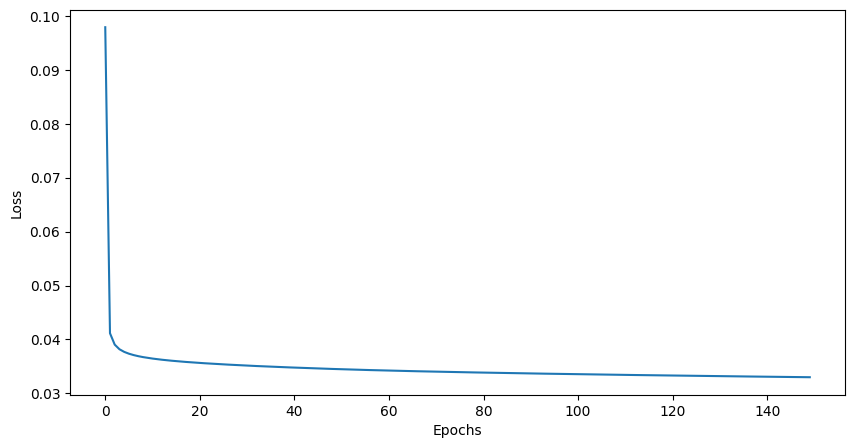

In [72]:
action_train_loss=train_model(model_action,optimizer_action,epochs, action_loader , len_train_dataset , len_test_dataset)
plot_loss(action_train_loss)
print(min(action_train_loss))

In [73]:
torch.save(model_action.state_dict(), f"model/HEBB-action.pth")
torch.save(action_train_loss, f"loss/action.pth")

### Evaluate

In [74]:
state_dict = torch.load(f"model/HEBB-action.pth")
model_action.load_state_dict(state_dict)

<All keys matched successfully>

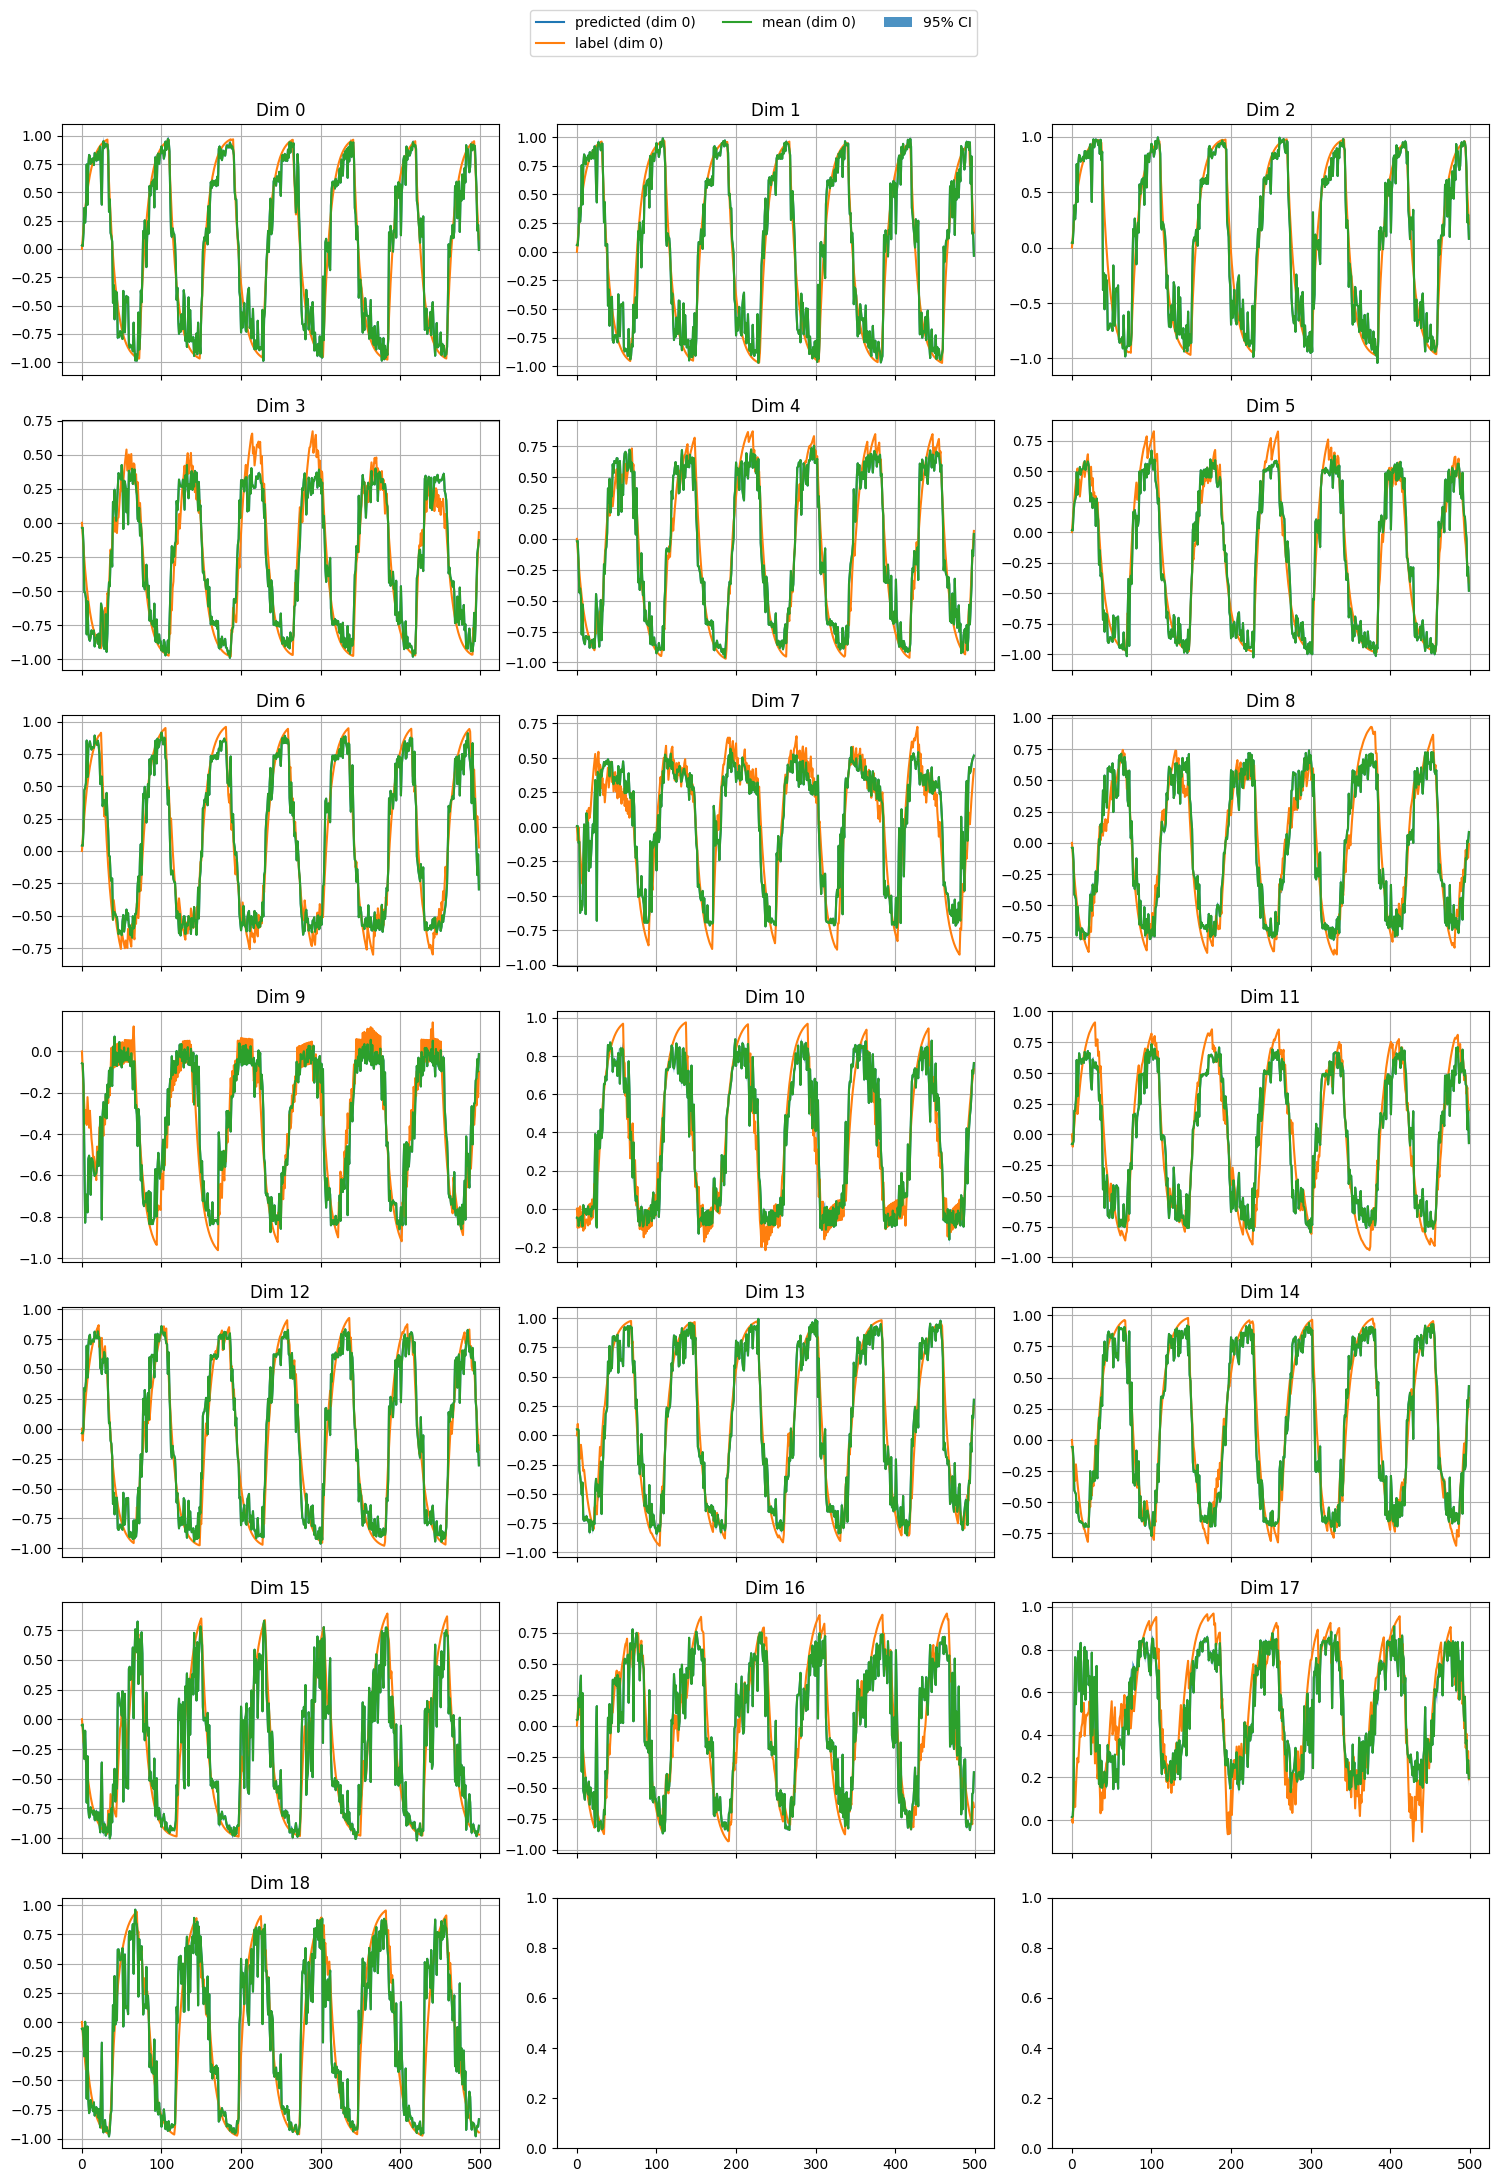

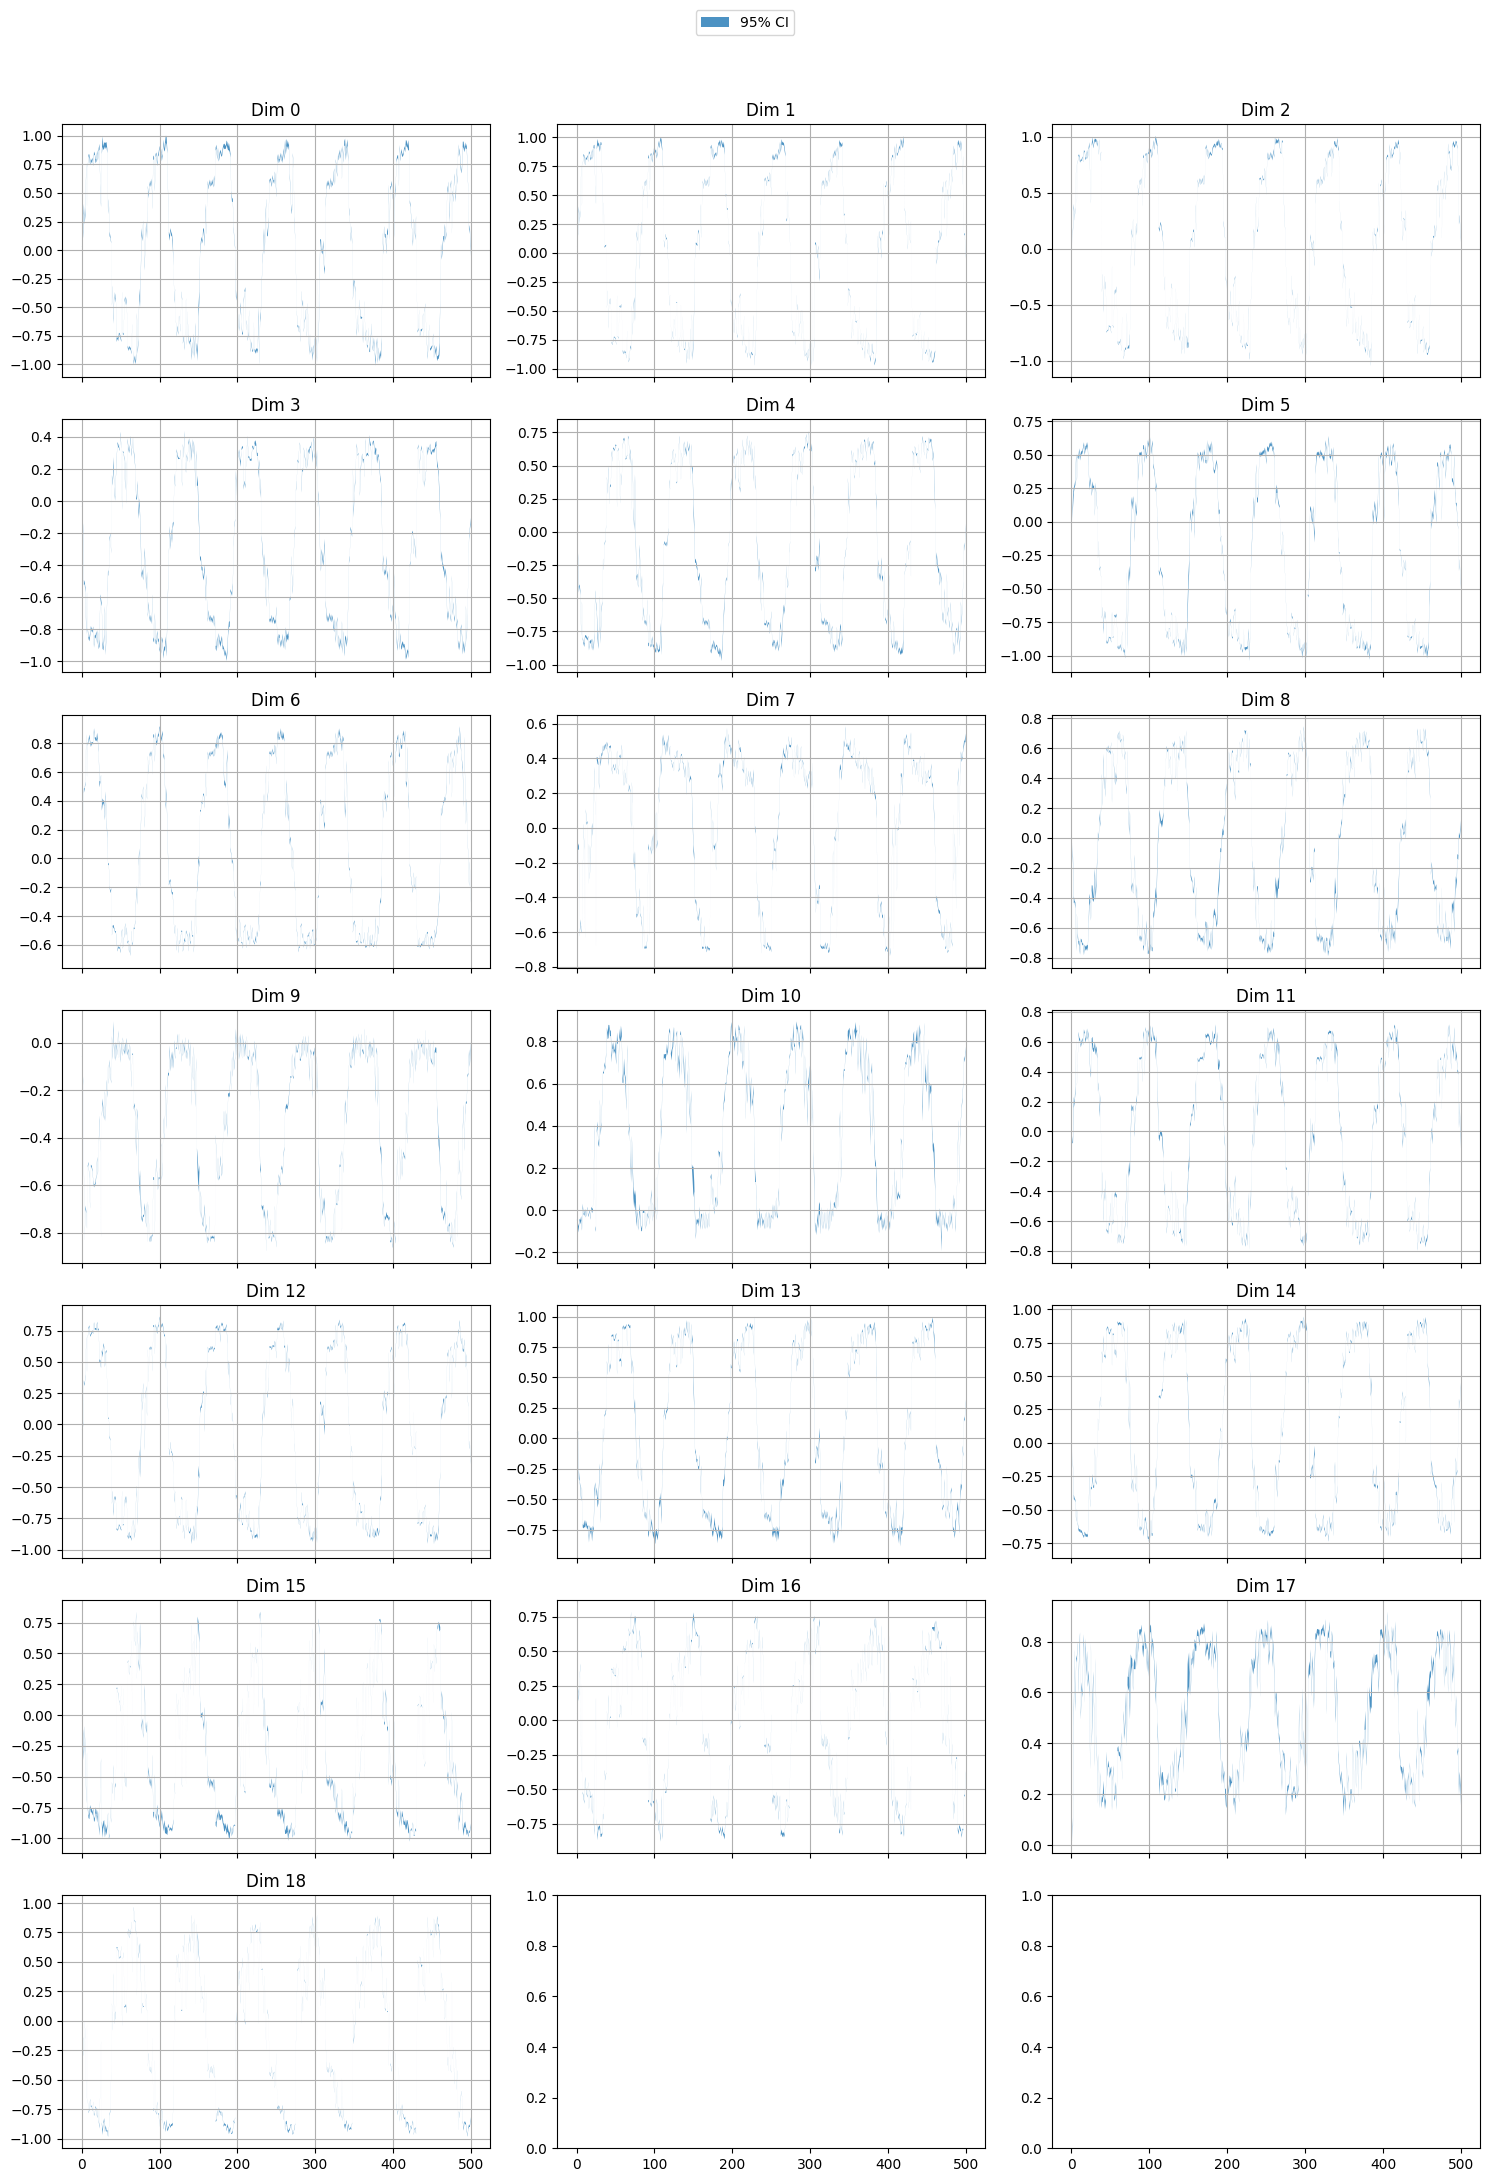

In [75]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_action, eva_input[:,action_index], eva_label)
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)

## IMU

In [76]:
batch_size = 16
hidden_dim = 1024
lr = 2.0425293364322738e-05

state_dim = len(IMU_index)

IMU_loader = DataLoader(IMU_dataset, batch_size=batch_size)

model_IMU = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_IMU = Adam(model_IMU.parameters(), lr=lr)

Epoch 1/150 | Train Loss: 0.203946
Epoch 2/150 | Train Loss: 0.182617
Epoch 3/150 | Train Loss: 0.172233
Epoch 4/150 | Train Loss: 0.158183
Epoch 5/150 | Train Loss: 0.143353
Epoch 6/150 | Train Loss: 0.132307
Epoch 7/150 | Train Loss: 0.126042
Epoch 8/150 | Train Loss: 0.122076
Epoch 9/150 | Train Loss: 0.119056
Epoch 10/150 | Train Loss: 0.116570
Epoch 11/150 | Train Loss: 0.114398
Epoch 12/150 | Train Loss: 0.112374
Epoch 13/150 | Train Loss: 0.110331
Epoch 14/150 | Train Loss: 0.108252
Epoch 15/150 | Train Loss: 0.106212
Epoch 16/150 | Train Loss: 0.104268
Epoch 17/150 | Train Loss: 0.102430
Epoch 18/150 | Train Loss: 0.100668
Epoch 19/150 | Train Loss: 0.099066
Epoch 20/150 | Train Loss: 0.097649
Epoch 21/150 | Train Loss: 0.096416
Epoch 22/150 | Train Loss: 0.095328
Epoch 23/150 | Train Loss: 0.094350
Epoch 24/150 | Train Loss: 0.093468
Epoch 25/150 | Train Loss: 0.092683
Epoch 26/150 | Train Loss: 0.091985
Epoch 27/150 | Train Loss: 0.091361
Epoch 28/150 | Train Loss: 0.090800
E

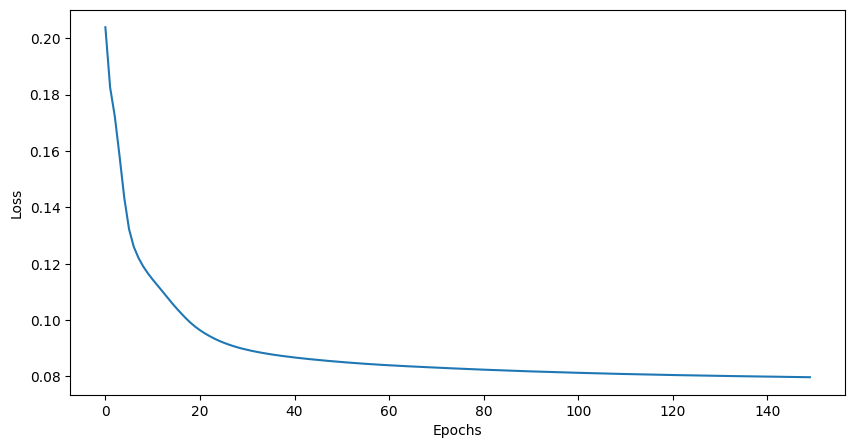

In [77]:
IMU_train_loss=train_model(model_IMU,optimizer_IMU,epochs, IMU_loader , len_train_dataset , len_test_dataset)
plot_loss(IMU_train_loss)
print(min(IMU_train_loss))

In [78]:
torch.save(model_IMU.state_dict(), f"model/HEBB-IMU.pth")
torch.save(IMU_train_loss, f"loss/IMU.pth")

### Evaluate

In [79]:

state_dict = torch.load(f"model/HEBB-IMU.pth")
model_IMU.load_state_dict(state_dict)

<All keys matched successfully>

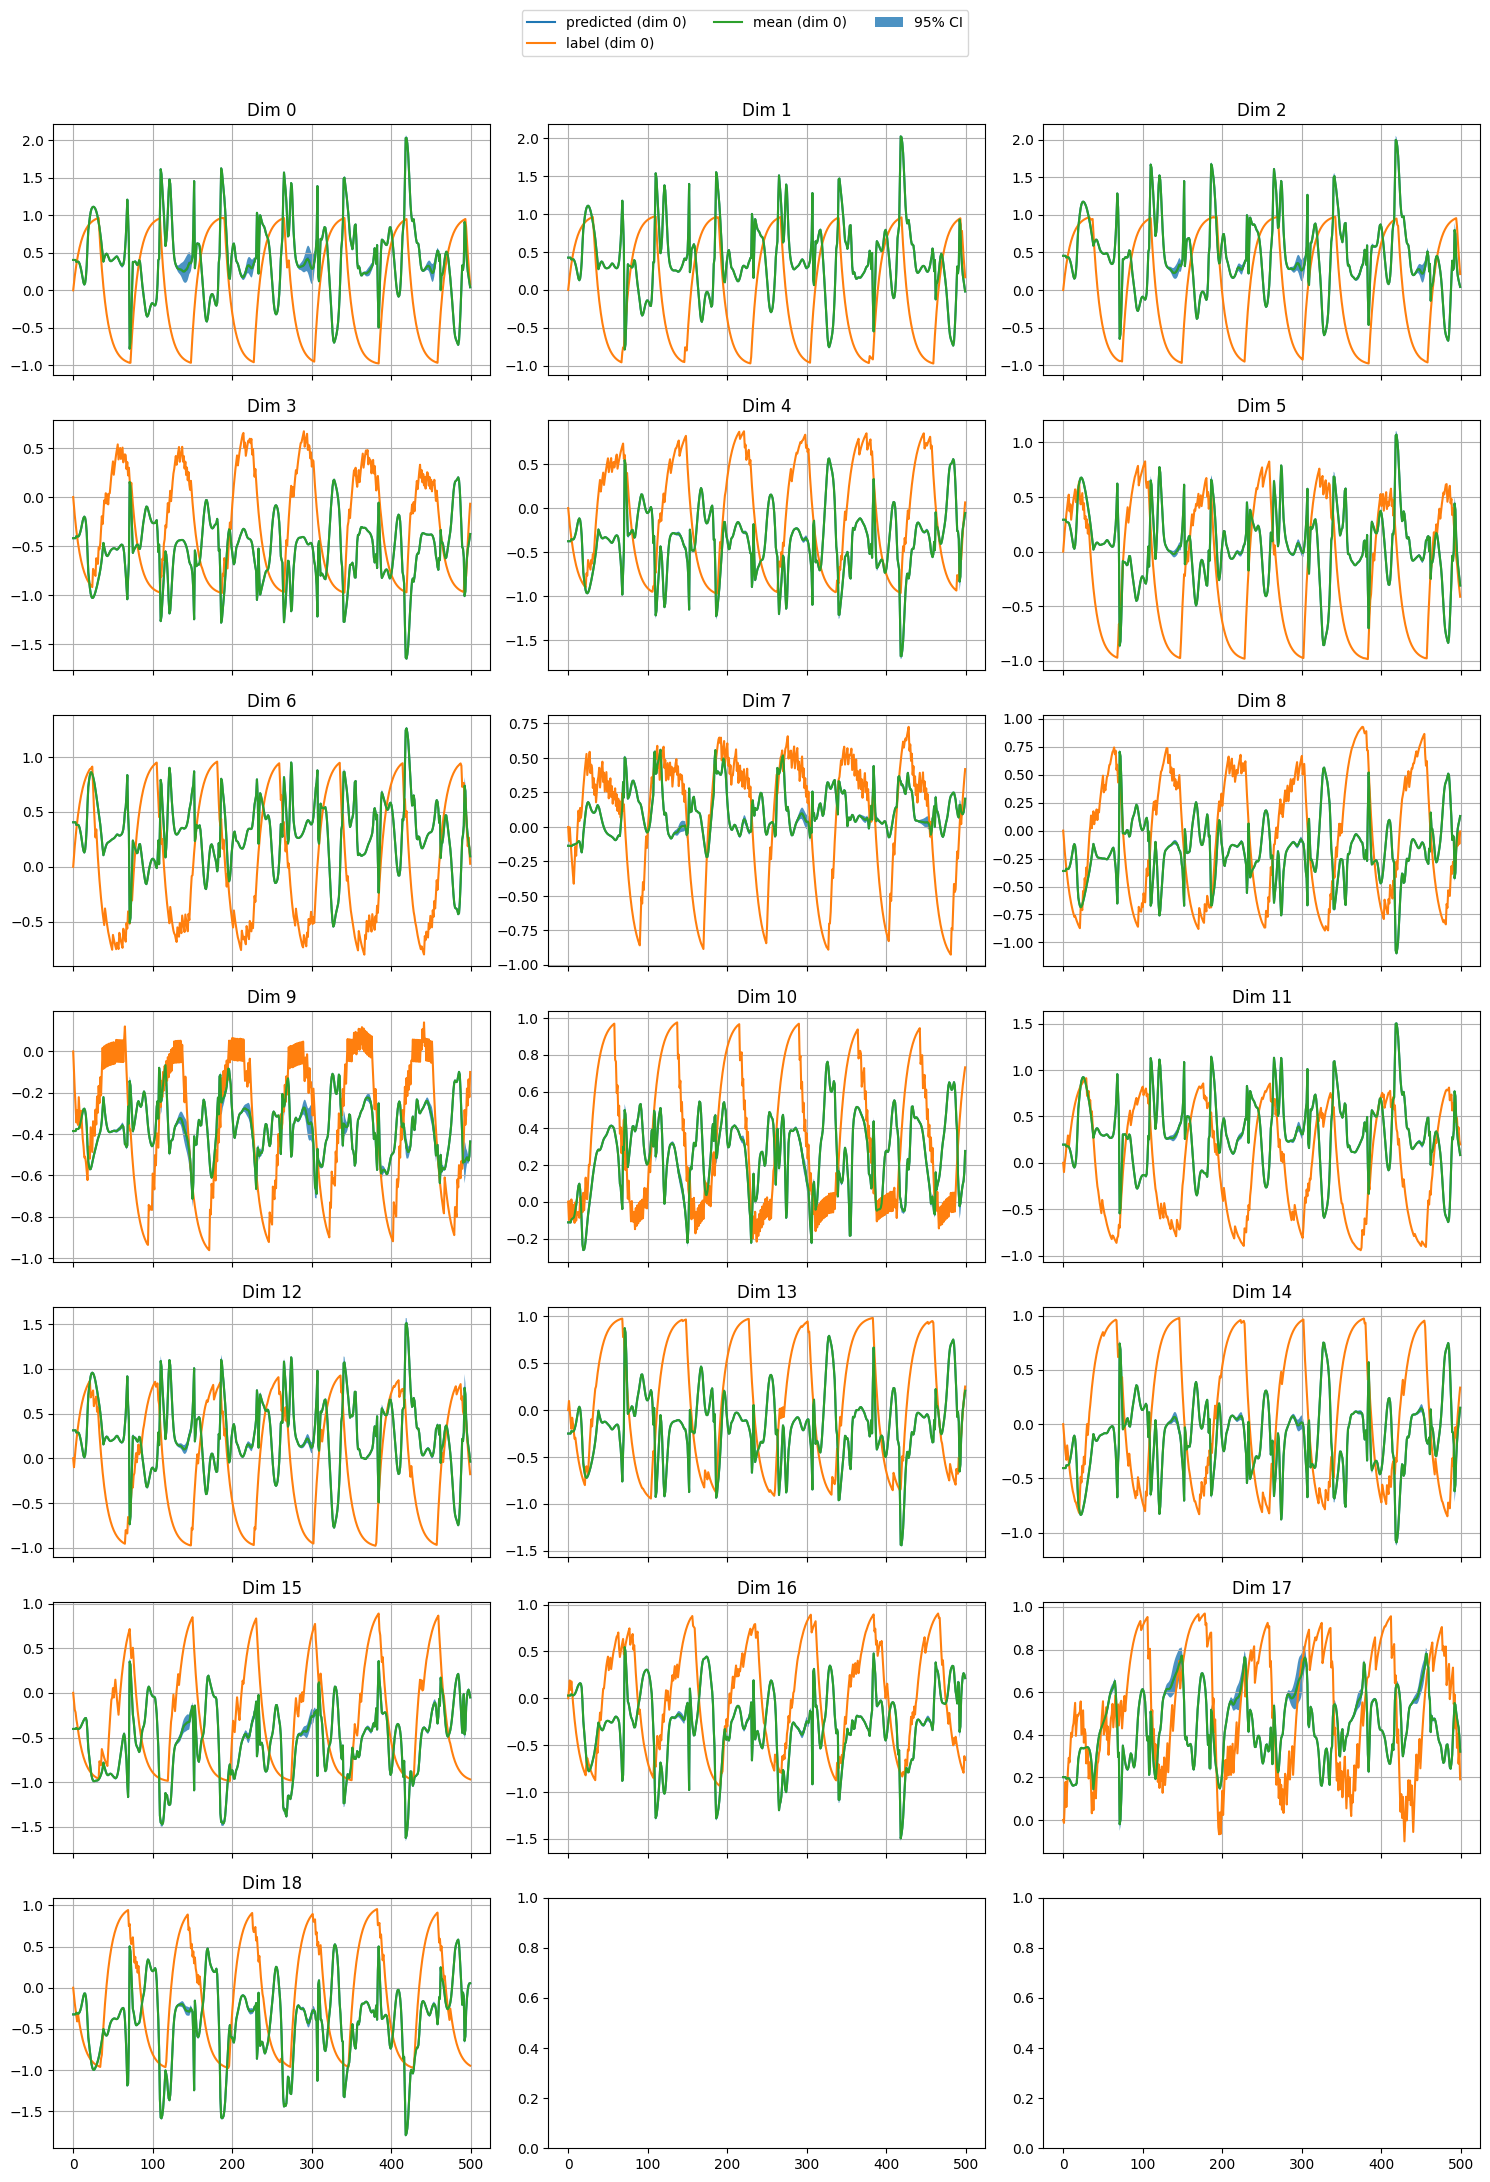

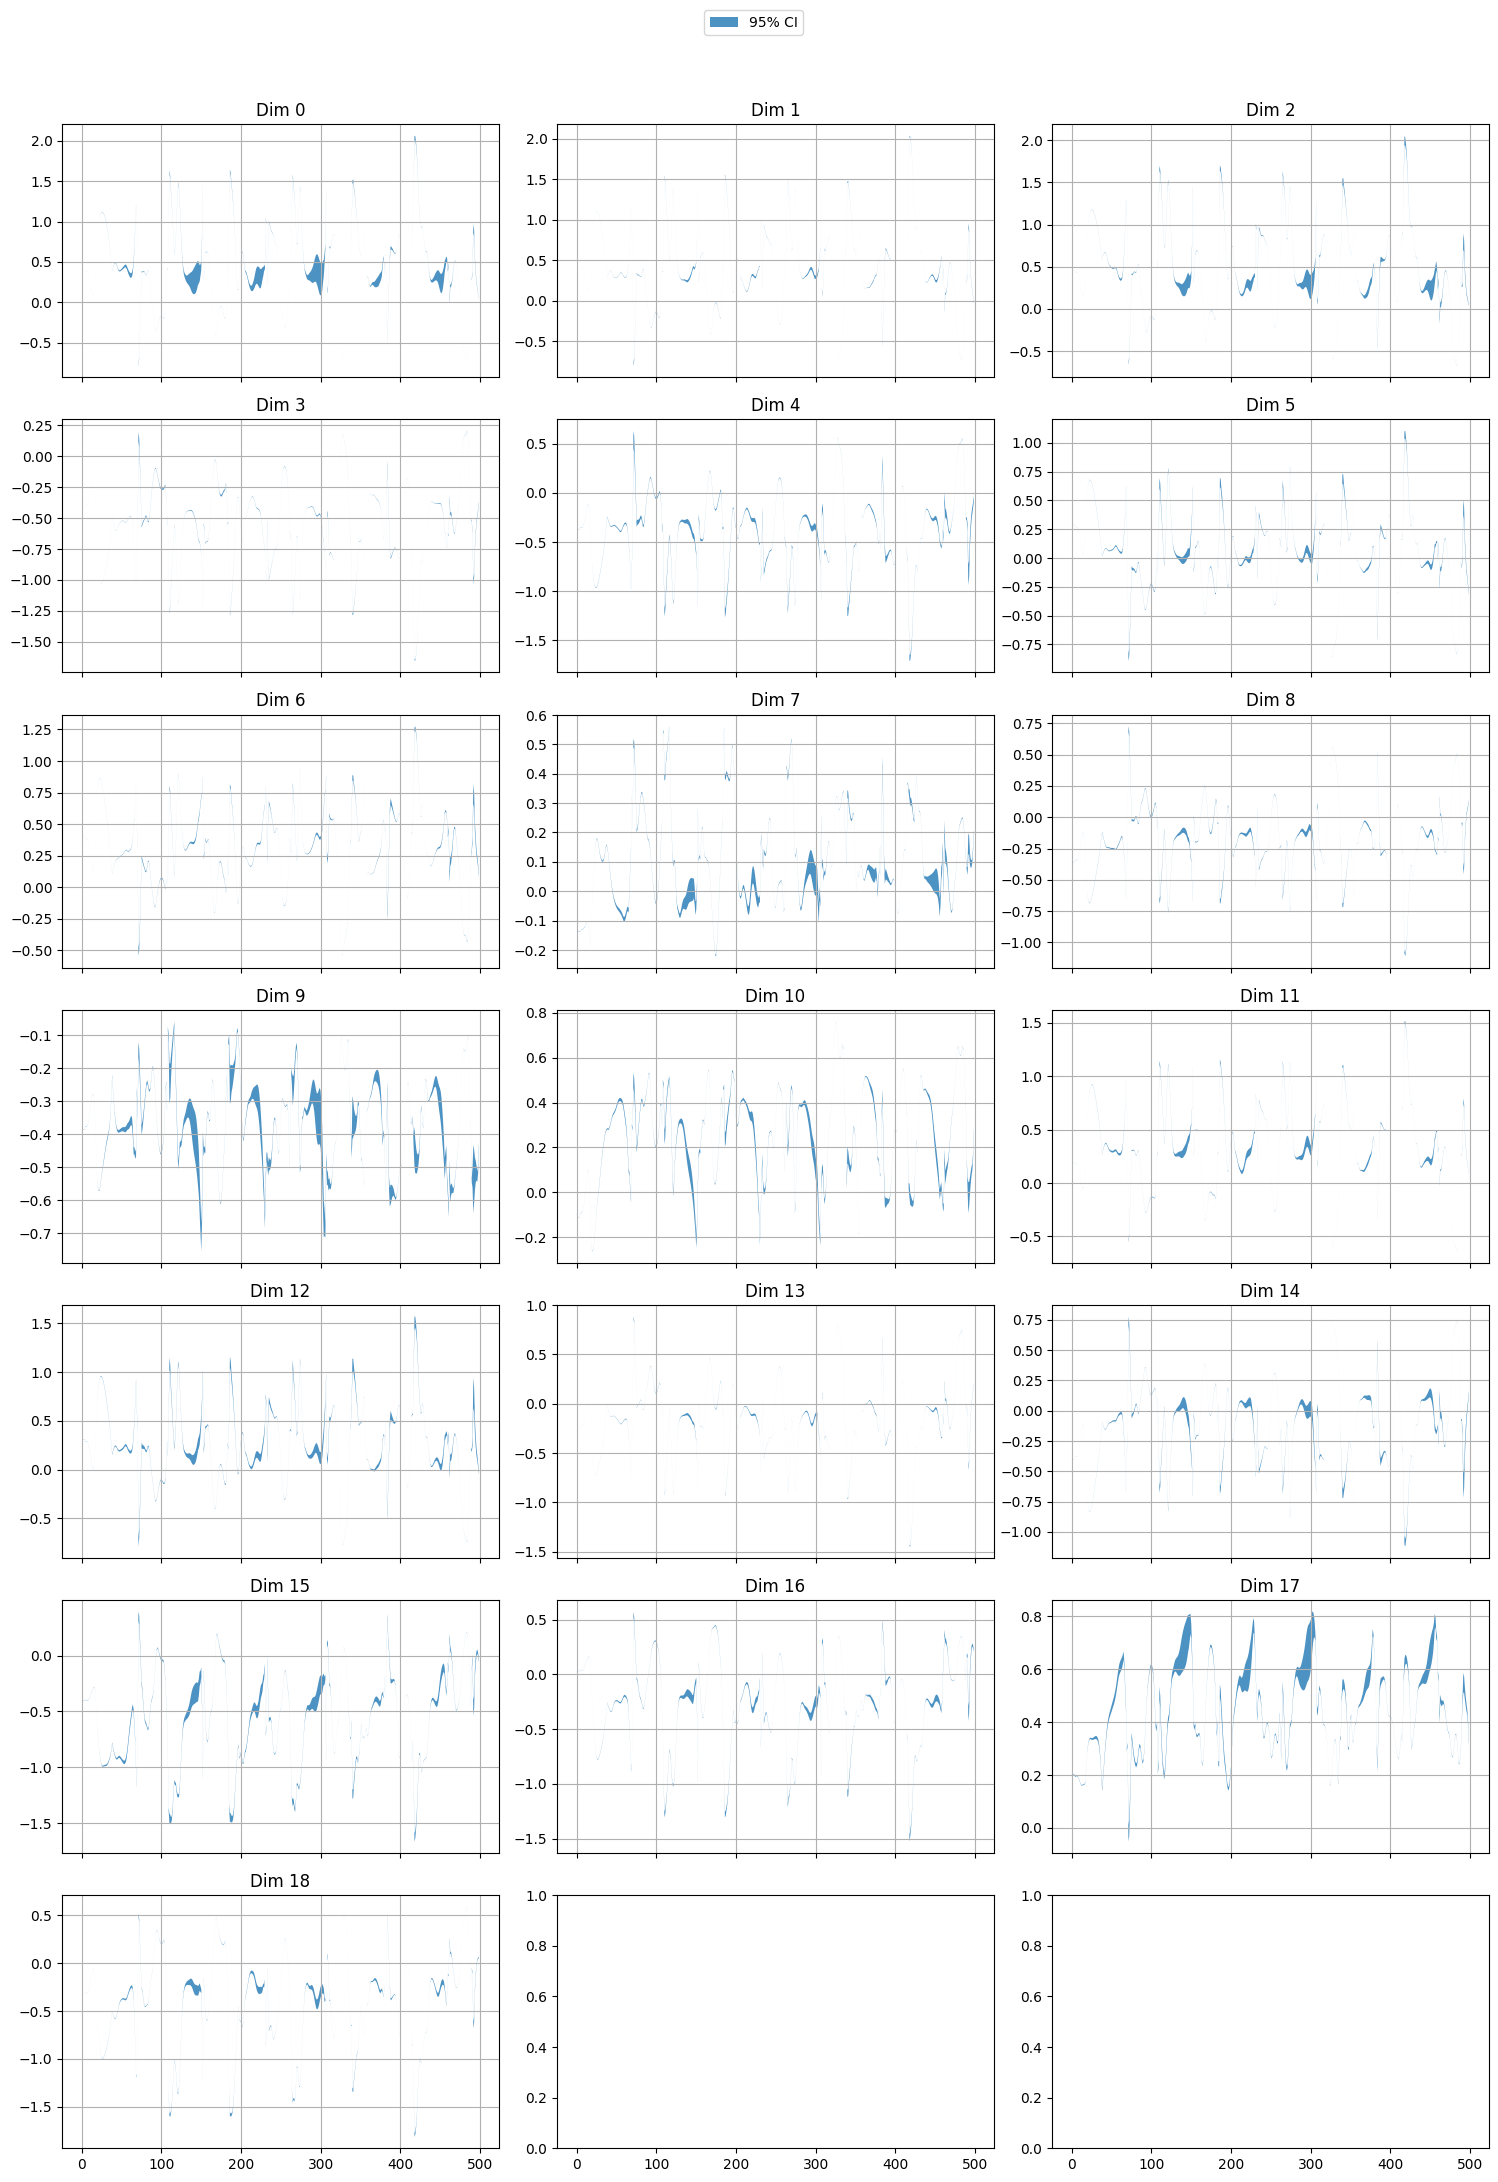

In [80]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_IMU, eva_input[:,IMU_index], eva_label)
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)

## Foot Contact

In [81]:
batch_size = 16
hidden_dim = 128
lr = 1.1236751914030148e-05

state_dim = len(fc_index)

fc_loader = DataLoader(fc_dataset, batch_size=batch_size)

model_fc = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_fc = Adam(model_IMU.parameters(), lr=lr)

Epoch 1/150 | Train Loss: 1.459888
Epoch 2/150 | Train Loss: 1.459822
Epoch 3/150 | Train Loss: 1.458932
Epoch 4/150 | Train Loss: 1.459254
Epoch 5/150 | Train Loss: 1.459810
Epoch 6/150 | Train Loss: 1.457097
Epoch 7/150 | Train Loss: 1.457289
Epoch 8/150 | Train Loss: 1.461504
Epoch 9/150 | Train Loss: 1.459061
Epoch 10/150 | Train Loss: 1.459903
Epoch 11/150 | Train Loss: 1.461281
Epoch 12/150 | Train Loss: 1.460202
Epoch 13/150 | Train Loss: 1.459931
Epoch 14/150 | Train Loss: 1.459061
Epoch 15/150 | Train Loss: 1.462495
Epoch 16/150 | Train Loss: 1.458488
Epoch 17/150 | Train Loss: 1.458244
Epoch 18/150 | Train Loss: 1.460342
Epoch 19/150 | Train Loss: 1.460676
Epoch 20/150 | Train Loss: 1.457486
Epoch 21/150 | Train Loss: 1.461115
Epoch 22/150 | Train Loss: 1.459474
Epoch 23/150 | Train Loss: 1.459652
Epoch 24/150 | Train Loss: 1.459446
Epoch 25/150 | Train Loss: 1.457629
Epoch 26/150 | Train Loss: 1.458839
Epoch 27/150 | Train Loss: 1.461853
Epoch 28/150 | Train Loss: 1.460547
E

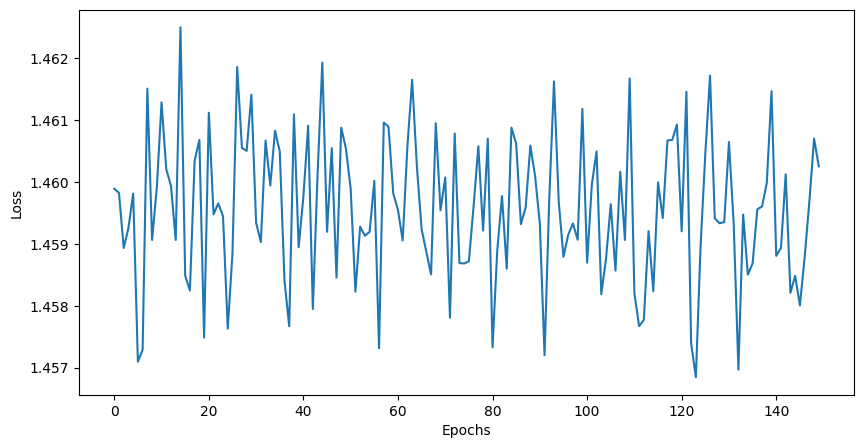

In [82]:
fc_train_loss=train_model(model_fc,optimizer_fc,epochs, fc_loader , len_train_dataset , len_test_dataset)
plot_loss(fc_train_loss)
print(min(fc_train_loss))

In [83]:
torch.save(model_fc.state_dict(), f"model/HEBB-fc.pth")
torch.save(fc_train_loss, f"loss/fc.pth")

### Evaluate

In [84]:

state_dict = torch.load(f"model/HEBB-fc.pth")
model_fc.load_state_dict(state_dict)

<All keys matched successfully>

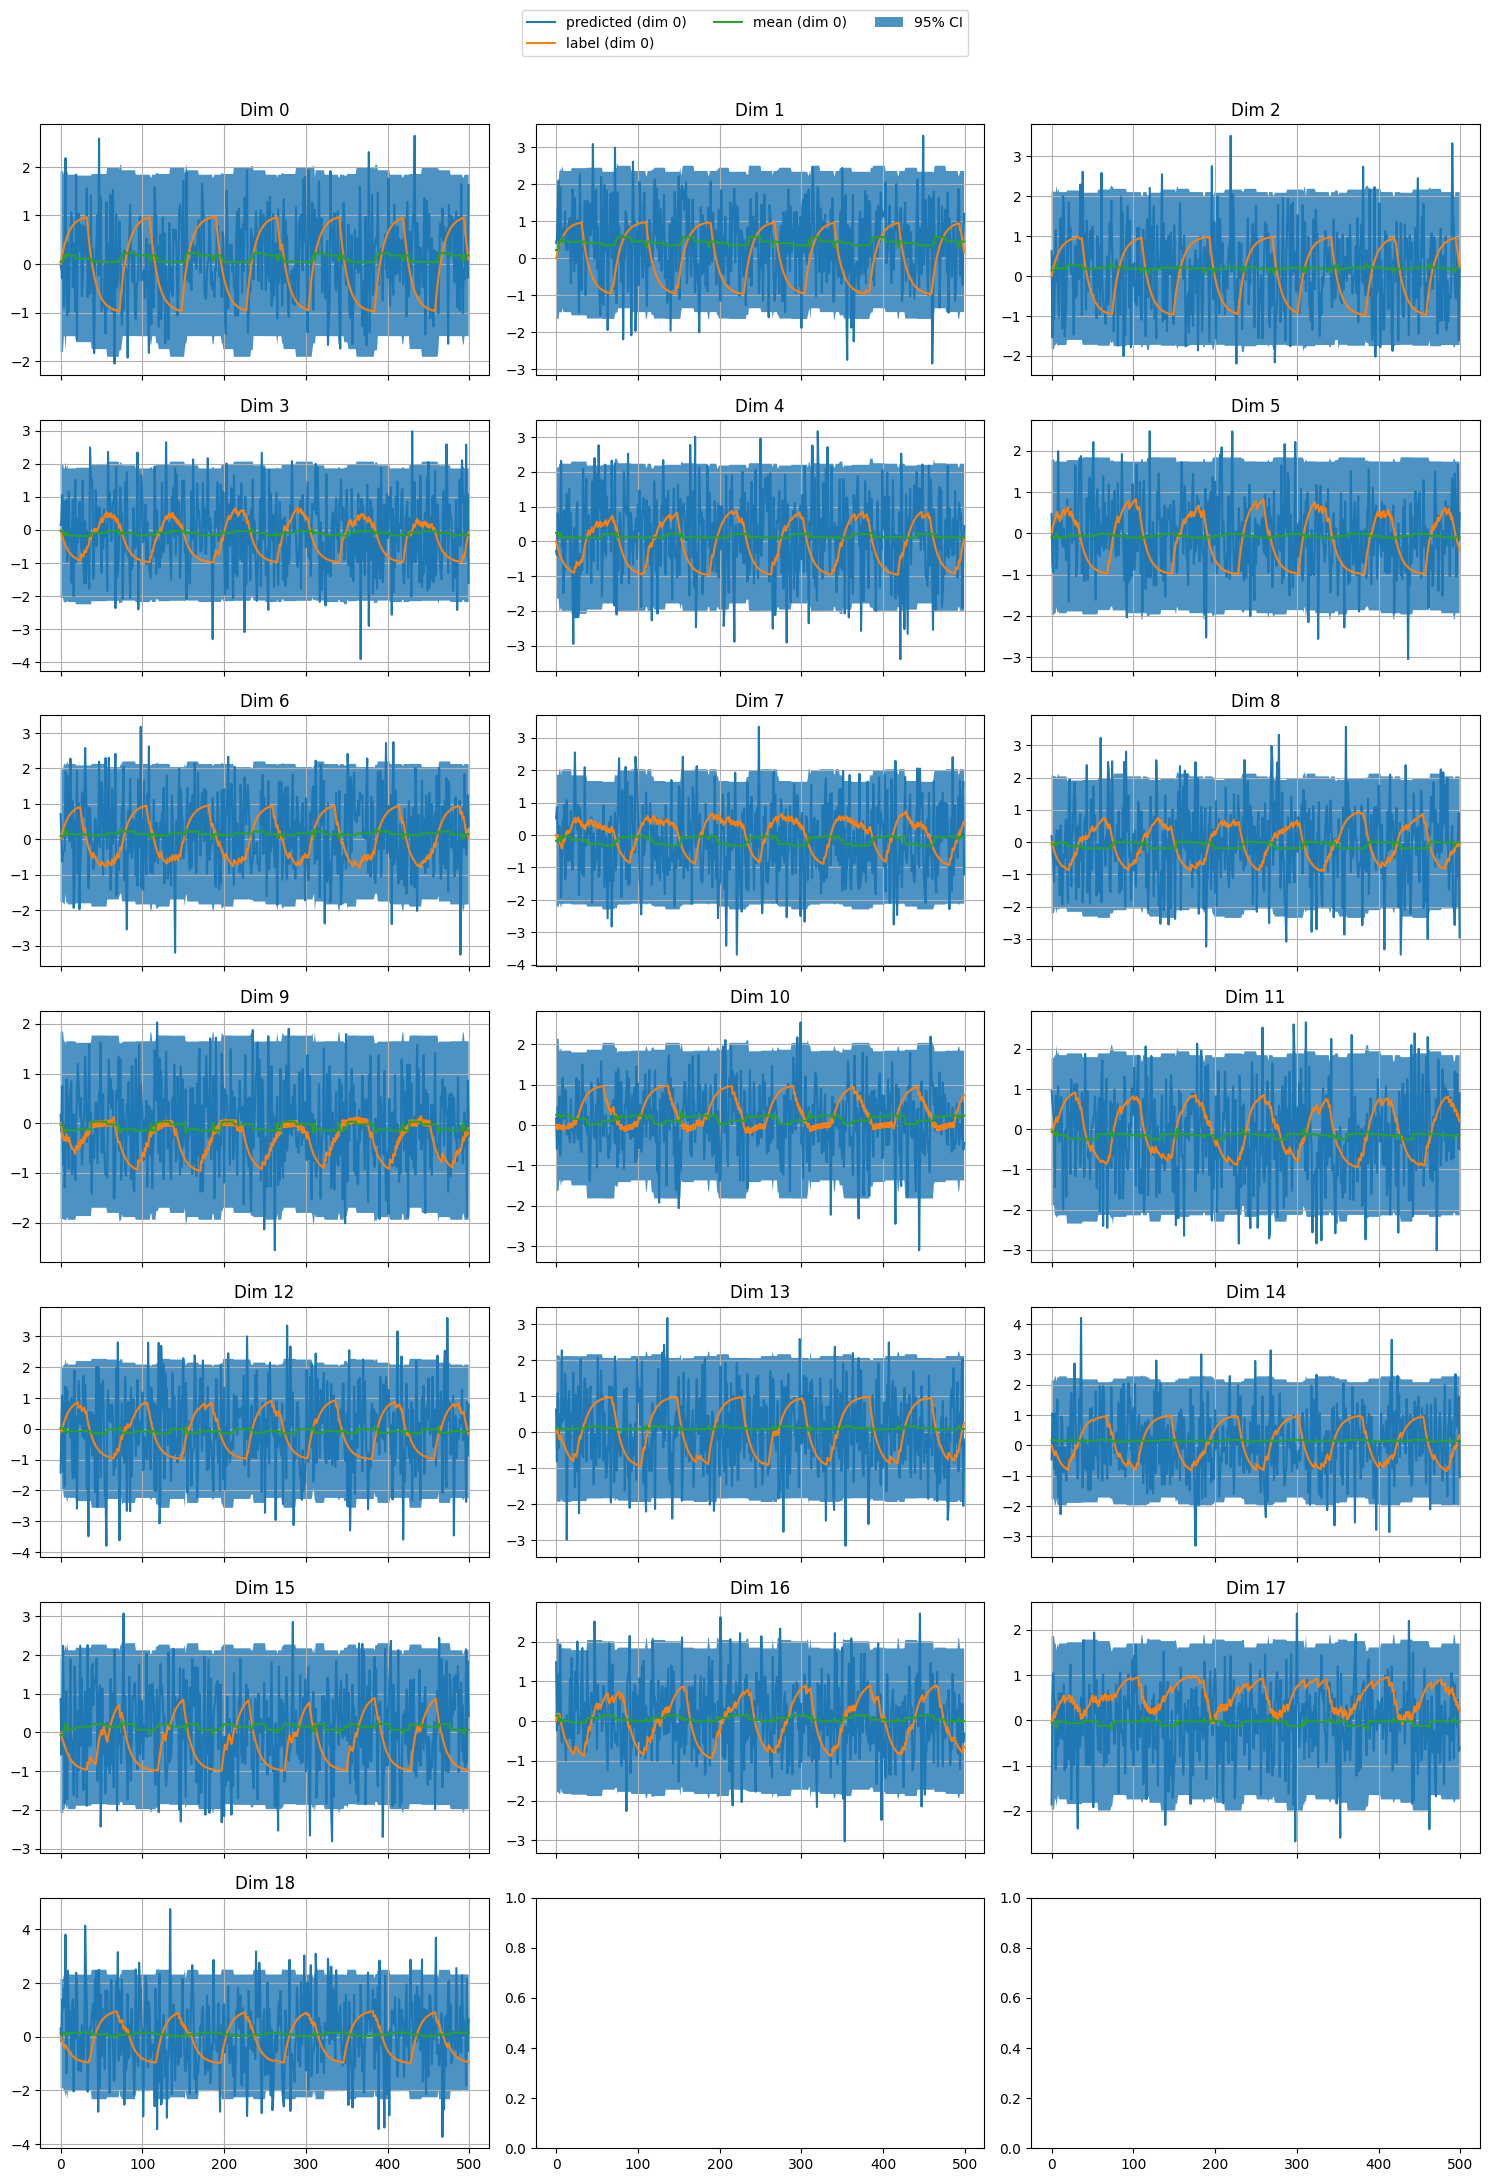

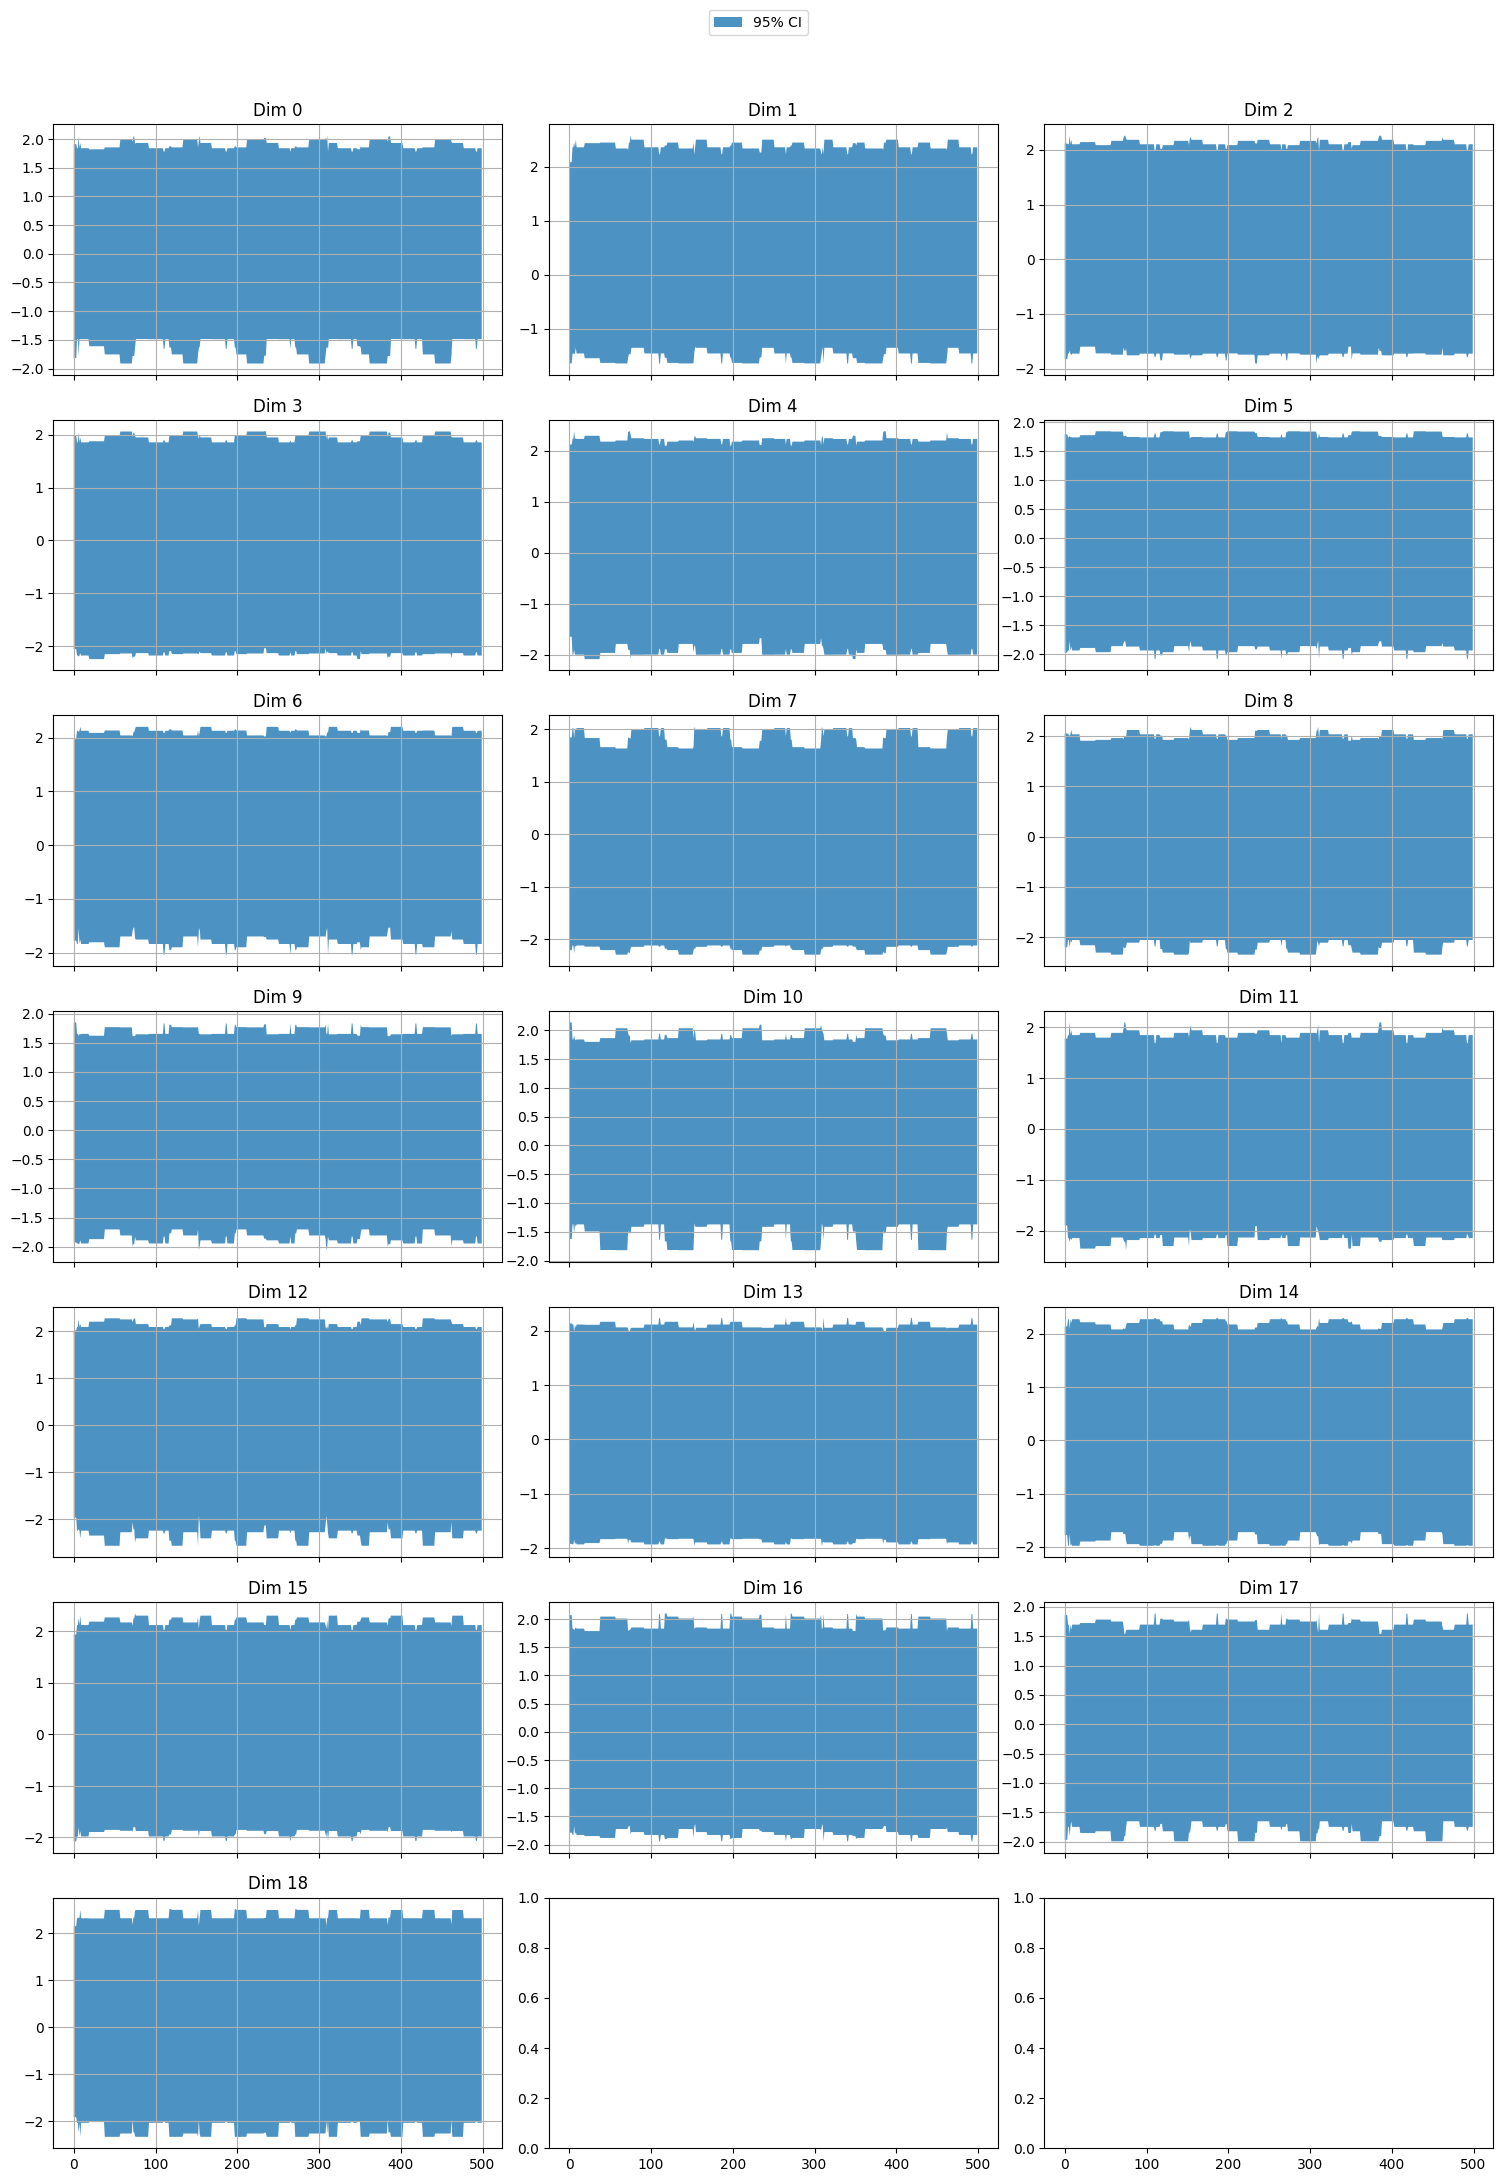

In [85]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_fc, eva_input[:,fc_index], eva_label)
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)